"We certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that we did not receive any external help, coaching or contributions during the production of this work."

# Final Project: MARL

We constructed the environment by referring to the MARL code of CSE 546 Spring 2022 class.

## Part 1 Multi-agent GridWorld Environment
---

### Import Necessary Modules

In [1]:
import numpy as np
import gym
from gym import spaces
import copy
from copy import copy
import matplotlib.pyplot as plt
import time

### Define the MARL Gridworld.

In [2]:
class MAGridworld(gym.Env):
    
    metadata = { 'render.modes': ['human', 'rgb_array'] }
    
    def __init__(self, size, num_agents):
        # the size of the Gridworld
        self.size = size
        self.observation_space = spaces.Box(low = 0,
                                            high = self.size,
                                            shape = (self.size,
                                                     self.size))
        # 5 types of actions: up, down, left, right, halt
        self.action_space = spaces.Discrete(5)
        # in case the horizontal and vertical lengths change..
        self._grid_size = (self.size, self.size)
        self.world = np.zeros((self._grid_size))
        # the interval between initial positions of players
        self.interval = int((self.size - 1) / (num_agents - 1))
        # the number of players in the game
        self.num_agents = num_agents
        self._timestep = None
        self._max_timestep = int(self.size * 4)
        self._step_cost = -0.1
        
    def reset(self):
        self.agent_pos = []
        self.goal_pos = []
        self._timestep = 0
        for i in range(self.num_agents):
            self.agent_pos.append([self.size - 1, i * self.interval])
            self.goal_pos.append([0, i * self.interval])
        self.done = [False] * self.num_agents
        self.goal_pos.reverse()
        observation = self.agent_pos
        return observation
    
    # to measure the distance between an agent's position and the goal
    def _compute_distance(self, x, y):
        dist = np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])
        return dist
    
    def _is_collision(self, new_pos, agent):
        for i in range(self.num_agents):
            if i == agent:
                continue
            elif new_pos == self.agent_pos[i]:
                return True
            elif new_pos == self.goal_pos[i]:
                return True
            
    def step(self, actions):
        # Instantiate dones.
        self._timestep += 1
        old_pos = self.agent_pos.copy()
        # Instantiate rewards.
        rewards = [0] * self.num_agents
        # the next states and the rewards for each player
        for agent in range(self.num_agents):
            next_pos = copy(self.agent_pos[agent])
            # the next states
            if actions[agent] == 0: # down
                next_pos[0] += 1
            elif actions[agent] == 1: # up
                next_pos[0] -= 1
            elif actions[agent] == 2: # right
                next_pos[1] += 1
            elif actions[agent] == 3: # left
                next_pos[1] -= 1
            elif actions[agent] == 4: # halt
                pass
            else:
                raise Exception("The Action is not valid.")
            # for safety of the environment
            next_pos[0] = np.clip(next_pos[0], 0, self.size - 1)
            next_pos[1] = np.clip(next_pos[1], 0, self.size - 1)
            # First Come First Served.
            # The priority is given to the new position in the order of index.
            if not self._is_collision(next_pos, agent):
                self.agent_pos[agent] = next_pos
            else:
                pass 
            # the rewards
            old_dist = self._compute_distance(old_pos[agent],
                                              self.goal_pos[agent])
            new_dist = self._compute_distance(self.agent_pos[agent],
                                              self.goal_pos[agent])
            if new_dist == 0:
                self.done[agent] = True
                rewards[agent] = 1
            else:
                if new_dist < old_dist:
                    rewards[agent] = -0.1
                else:
                    rewards[agent] = -0.5

        if self._timestep >= self._max_timestep:
            self.done = [True] * self.num_agents    
        
        observation = self.agent_pos
        info = {}
        return observation, rewards, self.done, info
    
    def render(self):
        state = np.copy(self.world)
        for i in range(self.num_agents):
            state[tuple(self.agent_pos[i])] = 0.2 + 0.2 * i
            state[tuple(self.goal_pos[i])] = 1 - (0.2 * i)
        return plt.imshow(state)

### Environment Settings

In [3]:
config = {
    'NUM_AGENTS': 2,
    'GRID_SIZE': 5
}

### Check if `MAGridworld` works properly.

AI safety check

States:	  [[4, 0], [3, 4]]
Rewards:  [-0.5, -0.1]
dones:	  [False, False]


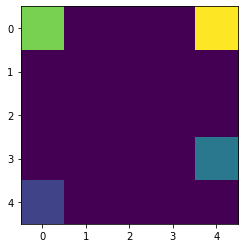

In [4]:
if __name__ == '__main__':
    num_agents = config['NUM_AGENTS']
    size = config['GRID_SIZE']
    env = MAGridworld(size = size, num_agents = num_agents)
    env.reset()
    env.render()
    action_n = [0, 1]
    state, reward, done, _ = env.step(action_n)
    print('States:\t ', state)
    print('Rewards: ', reward)
    print('dones:\t ', done)
    env.render()

Collision Case

States:	  [[3, 0], [3, 4]]
Rewards:  [-0.1, -0.1]
dones:	  [False, False]


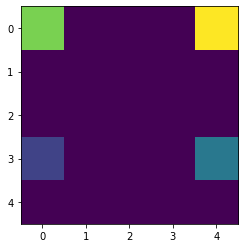

In [5]:
if __name__ == '__main__':
    num_agents = config['NUM_AGENTS']
    size = config['GRID_SIZE']
    env = MAGridworld(size = size, num_agents = num_agents)
    env.reset()
    env.render()
    action_n = [1, 1]
    next_state, reward, done, _ = env.step(action_n)
    print('States:\t ', next_state)
    print('Rewards: ', reward)
    print('dones:\t ', done)
    env.render()

States:	  [[3, 1], [3, 3]]
Rewards:  [-0.1, -0.1]
dones:	  [False, False]


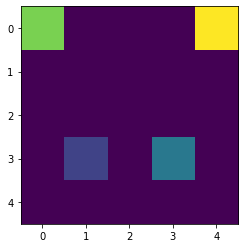

In [6]:
action_n = [2, 3]
next_state, reward, done, _ = env.step(action_n)
print('States:\t ', next_state)
print('Rewards: ', reward)
print('dones:\t ', done)
env.render()

States:	  [[3, 2], [3, 3]]
Rewards:  [-0.1, -0.5]
dones:	  [False, False]


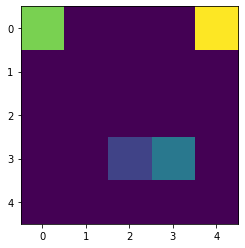

In [7]:
action_n = [2, 3]
next_state, reward, done, _ = env.step(action_n)
print('States:\t ', next_state)
print('Rewards: ', reward)
print('dones:\t ', done)
env.render()

### Applying Tabular Method (Q-learning)

We refer to the Q-learning agent class which was built by `spark55`'s Assignment 1.

In [8]:
# Constructor for Time Difference Agent
class TDAgent:
    def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 eps: float, # the parameter for epsilon-greedy policy
                 lr: float, # learning rate
                 num_steps: int):
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.lr = lr
        self.eps = eps
        self.num_steps = num_steps

        # Initialize state value function, 'V', and
        # action value function, 'Q'.
        self.v = None
        self.q = None
        self.reset_values()
        
        # Initialize "policy Q".
        # "policy Q" is the one used for policy generation.
        self._policy_q = None
        self.reset_policy()

    def reset_values(self):
        self.v = np.zeros(shape = self.num_states)
        self.q = np.zeros(shape = (self.num_states, self.num_actions))

    def reset_policy(self):
        self._policy_q = np.zeros(shape = (self.num_states, self.num_actions))

    def get_action(self, state):
        prob = np.random.uniform(0.0, 1.0, 1)
        # epsilon-greedy policy over Q
        if prob <= self.eps: # random policy with epsilon probability
            action = np.random.choice(range(self.num_actions))
        # greedy policy
        else:
            action = self._policy_q[state, :].argmax()
        return action

In [9]:
class QLearner(TDAgent):
    # All arguments except for the number of steps in TDAgent exist here.
    def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 eps: float,
                 lr: float):
        # Inherit TDAgent.
        super(QLearner, self).__init__(gamma = gamma,
                                       num_states = num_states,
                                       num_actions = num_actions,
                                       eps = eps,
                                       lr = lr,
                                       # Set this consistent with TD(n).
                                       # In this case, TD(0).
                                       num_steps = 1)

    def get_action(self, state):
        prob = np.random.uniform(0.0, 1.0, 1)
        # e-greedy policy over Q
        if prob <= self.eps: # random policy with epsilon probability
            action = np.random.choice(range(self.num_actions))
        # greedy policy
        else:
            action = self.q[state, :].argmax()
        return action

    def update_sample(self, state, action, reward, next_state, done):
        s, a, r, ns = state, action, reward, next_state
        # Q-Learning target
        td_target = r + self.gamma * self.q[ns, :].max() * (1 - done)
        self.q[s, a] += self.lr * (td_target - self.q[s, a])

### Algorithm Setting

In [10]:
num_episodes = 2000
gamma = 0.99
lr = 0.002
eps = 1.0
factor = (1e-2)**(1 / num_episodes)
num_states = env.observation_space.shape[0] * env.observation_space.shape[1]
num_actions = env.action_space.n

### Instantiate two agents.

In [11]:
env = MAGridworld(size = size, num_agents = num_agents)
qlearning_agent1 = QLearner(gamma = gamma,
                            num_states = num_states,
                            num_actions = num_actions,
                            eps = eps,
                            lr = lr)
qlearning_agent2 = QLearner(gamma = gamma,
                            num_states = num_states,
                            num_actions = num_actions,
                            eps = eps,
                            lr = lr)

### Training

In [12]:
start = time.time()

qlearning_rewards1 = []
qlearning_rewards2 = []
eps_values = []
print_every = 500

for ep in range(num_episodes):
    states = [env.reset()[0][0] * config['GRID_SIZE'] + env.reset()[0][1],
              env.reset()[1][0] * config['GRID_SIZE'] + env.reset()[1][1]]
    total_reward1 = 0
    total_reward2 = 0
    
    while True:
        # epsilon-greedy policy
        actions = [qlearning_agent1.get_action(states[0]),
                   qlearning_agent2.get_action(states[1])]
        _, rewards, dones, _ = env.step(actions)
        next_states = [env.agent_pos[0][0] * config['GRID_SIZE'] + env.agent_pos[0][1],
                       env.agent_pos[1][0] * config['GRID_SIZE'] + env.agent_pos[1][1]]
        
        # Q-learning: Update Q-table using greedy policy.
        qlearning_agent1.update_sample(state = states[0],
                                       action = actions[0],
                                       reward = rewards[0],
                                       next_state = next_states[0],
                                       done = dones[0])
        qlearning_agent2.update_sample(state = states[1],
                                       action = actions[1],
                                       reward = rewards[1],
                                       next_state = next_states[1],
                                       done = dones[1])
        
        total_reward1 += rewards[0]
        total_reward2 += rewards[1]
        
        states = next_states
        
        if dones[0] or dones[1]:
            break
            
    qlearning_rewards1.append(total_reward1)
    qlearning_rewards2.append(total_reward2)
    
    eps_values.append(qlearning_agent1.eps)
    
    qlearning_agent1.eps *= factor
    qlearning_agent2.eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {qlearning_agent1.eps:.2f}")
        
end = time.time()

print(f"For 2 agents, the elapsed time: {round(end - start, 1)} seconds")

Episode: 500	| Epsilon: 0.32
Episode: 1000	| Epsilon: 0.10
Episode: 1500	| Epsilon: 0.03
Episode: 2000	| Epsilon: 0.01
For 2 agents, the elapsed time: 2.1 seconds


### Visualization

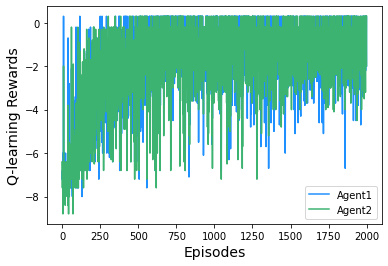

In [13]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(qlearning_rewards1, color = "dodgerblue")
ax.plot(qlearning_rewards2, color = "mediumseagreen")
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Q-learning Rewards", color = "black", fontsize = 14)
plt.legend(['Agent1', 'Agent2'])
plt.show()

Epsilon Decay

Text(0.5, 1.0, 'Decaying Epsilon')

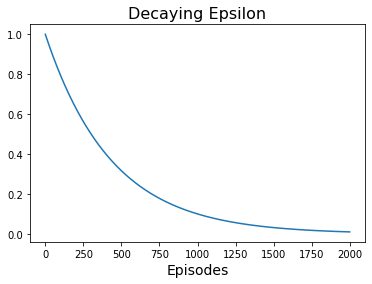

In [14]:
plt.plot(eps_values)
plt.xlabel("Episodes", fontsize = 14)
plt.title("Decaying Epsilon", fontsize = 16)

Check if the agents arrive at their destinations (Greedy Policy).

Step 1


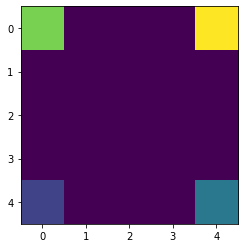

Step 2


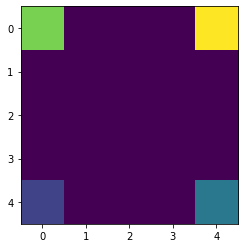

Step 3


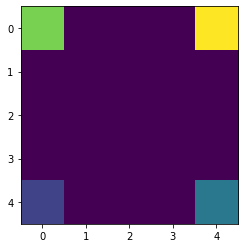

Step 4


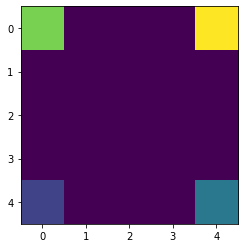

Step 5


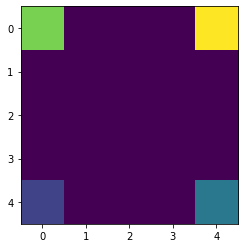

Step 6


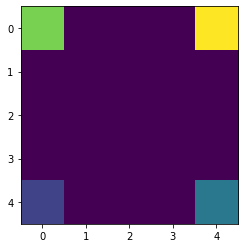

Step 7


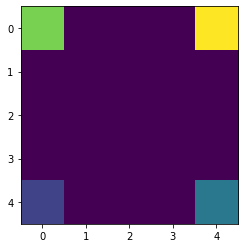

Step 8


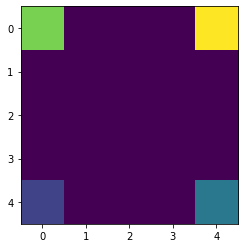

Step 9


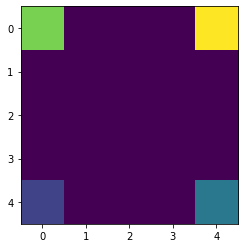

Step 10


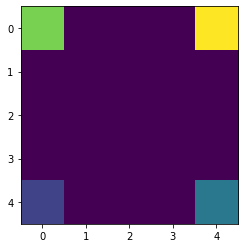

Step 11


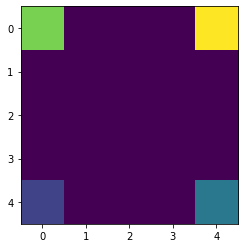

Step 12


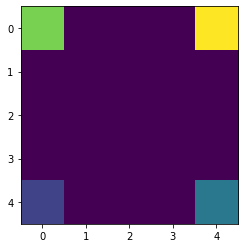

Step 13


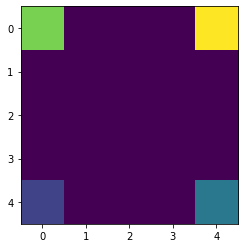

Step 14


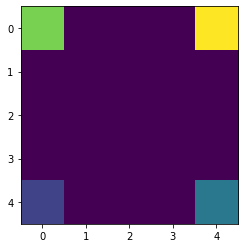

Step 15


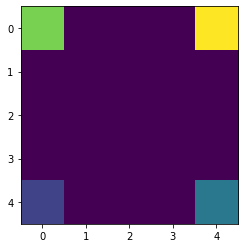

Step 16


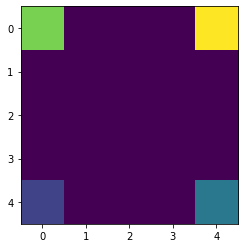

Step 17


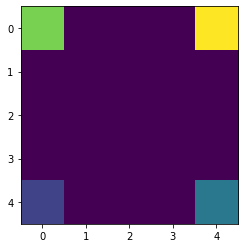

Step 18


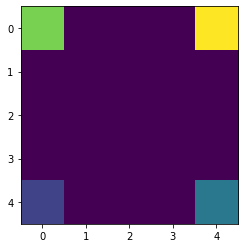

Step 19


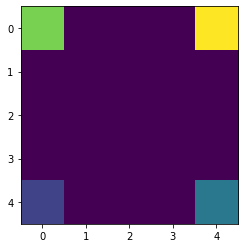

Step 20


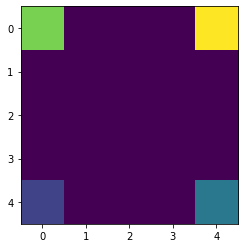

In [15]:
env.reset()
states = [env.reset()[0][0] * config['GRID_SIZE'] + env.reset()[0][1],
          env.reset()[1][0] * config['GRID_SIZE'] + env.reset()[1][1]]

# Only carry out the optimal policy trained via Q-learning.
qlearning_agent1.eps = 0.0
qlearning_agent2.eps = 0.0
count = 0

while True:
    actions = [qlearning_agent1.get_action(states[0]),
               qlearning_agent2.get_action(states[1])]
    _, rewards, dones, _ = env.step(actions)
    next_states = [env.agent_pos[0][0] * config['GRID_SIZE'] + env.agent_pos[0][1],
                   env.agent_pos[1][0] * config['GRID_SIZE'] + env.agent_pos[1][1]]
    states = next_states
    count += 1

    print(f"Step {count}")
    env.render()
    plt.show()
    time.sleep(1)
    
    if dones[0] + dones[1] > 0:
        break

There exist undesirable outcomes.

## Part 2 How can we resolve the collision?
---

Environment with priority (for the first agent)

In [16]:
class MAGridworld(gym.Env):
    
    metadata = { 'render.modes': ['human', 'rgb_array'] }
    
    def __init__(self, size, num_agents):
        # the size of the Gridworld
        self.size = size
        self.observation_space = spaces.Box(low = 0,
                                            high = self.size,
                                            shape = (self.size,
                                                     self.size))
        # 5 types of actions: up, down, left, right, halt
        self.action_space = spaces.Discrete(5)
        # in case the horizontal and vertical lengths change..
        self._grid_size = (self.size, self.size)
        self.world = np.zeros((self._grid_size))
        # the interval between initial positions of players
        self.interval = int((self.size - 1) / (num_agents - 1))
        # the number of players in the game
        self.num_agents = num_agents
        self._timestep = None
        self._max_timestep = int(self.size * 4)
        self._step_cost = -0.1
        
    def reset(self):
        self.agent_pos = []
        self.goal_pos = []
        self._timestep = 0
        for i in range(self.num_agents):
            self.agent_pos.append([self.size - 1, i * self.interval])
            self.goal_pos.append([0, i * self.interval])
        self.done = [False] * self.num_agents
        self.goal_pos.reverse()
        observation = self.agent_pos
        return observation
    
    # to measure the distance between an agent's position and the goal
    def _compute_distance(self, x, y):
        dist = np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])
        return dist
    
    def _is_collision(self, new_pos, agent):
        for i in range(self.num_agents):
            if i == agent:
                continue
            elif new_pos == self.agent_pos[i]:
                return True
            elif new_pos == self.goal_pos[i]:
                return True
            
    def step(self, actions):
        # Instantiate dones.
        self._timestep += 1
        old_pos = self.agent_pos.copy()
        # Instantiate rewards.
        rewards = [0] * self.num_agents
        # the next states and the rewards for each player
        
        for agent in range(self.num_agents):
            next_pos = copy(self.agent_pos[agent])
            # the next states
            if actions[agent] == 0: # down
                next_pos[0] += 1
            elif actions[agent] == 1: # up
                next_pos[0] -= 1
            elif actions[agent] == 2: # right
                next_pos[1] += 1
            elif actions[agent] == 3: # left
                next_pos[1] -= 1
            elif actions[agent] == 4: # halt
                pass
            else:
                raise Exception("The Action is not valid.")
            # for safety of the environment
            next_pos[0] = np.clip(next_pos[0], 0, self.size - 1)
            next_pos[1] = np.clip(next_pos[1], 0, self.size - 1)
            # First Come First Served.
            # The priority is given to the new position in the order of index.
            if not self._is_collision(next_pos, agent):
                self.agent_pos[agent] = next_pos
            else:
                pass 
            # the rewards
            old_dist = self._compute_distance(old_pos[agent],
                                              self.goal_pos[agent])
            new_dist = self._compute_distance(self.agent_pos[agent],
                                              self.goal_pos[agent])
            if new_dist == 0:
                self.done[agent] = True
                rewards[agent] = 1
            else:
                if new_dist < old_dist:
                    rewards[agent] = -0.1
                else:
                    rewards[agent] = -0.5

        if self._timestep >= self._max_timestep:
            self.done = [True] * self.num_agents    
        
        observation = self.agent_pos
        info = {}
        return observation, rewards, self.done, info
    
    def render(self):
        state = np.copy(self.world)
        for i in range(self.num_agents):
            state[tuple(self.agent_pos[i])] = 0.2 + 0.2 * i
            state[tuple(self.goal_pos[i])] = 1 - (0.2 * i)
        return plt.imshow(state)

Instantiate two agents.

In [17]:
qlearning_agent1_c = QLearner(gamma = gamma,
                              num_states = num_states,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)
qlearning_agent2_c = QLearner(gamma = gamma,
                              num_states = num_states,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)

Training agents in the environment with priority

In [18]:
repeats = 100
episode_reward_1 = [0] * num_episodes
episode_reward_2 = [0] * num_episodes
for repeat in range(repeats):
    print_every = 10
    qlearning_agent1_c = QLearner(gamma = gamma,
                              num_states = num_states,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)
    qlearning_agent2_c = QLearner(gamma = gamma,
                              num_states = num_states,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)

    for ep in range(num_episodes):
        states = [env.reset()[0][0] * config['GRID_SIZE'] + env.reset()[0][1],
                  env.reset()[1][0] * config['GRID_SIZE'] + env.reset()[1][1]]
        env.reset()
        total_reward1 = 0
        total_reward2 = 0

        while True:
            # epsilon-greedy policy
            actions = [qlearning_agent1_c.get_action(states[0]),
                       qlearning_agent2_c.get_action(states[1])]
            _, rewards, dones, _ = env.step(actions)
            next_states = [env.agent_pos[0][0] * config['GRID_SIZE'] + env.agent_pos[0][1],
                           env.agent_pos[1][0] * config['GRID_SIZE'] + env.agent_pos[1][1]]

            # Q-learning: Update Q-table using greedy policy.
            qlearning_agent1_c.update_sample(state = states[0],
                                             action = actions[0],
                                             reward = rewards[0],
                                             next_state = next_states[0],
                                             done = dones[0])
            qlearning_agent2_c.update_sample(state = states[1],
                                             action = actions[1],
                                             reward = rewards[1],
                                             next_state = next_states[1],
                                             done = dones[1])

            total_reward1 += rewards[0]
            total_reward2 += rewards[1]

            states = next_states

            if dones[0] or dones[1]:
                break

        qlearning_agent1_c.eps *= factor
        qlearning_agent2_c.eps *= factor

        episode_reward_1[ep] += total_reward1
        episode_reward_2[ep] += total_reward2
        
    if repeat % print_every == 9:
        print(f"The {repeat + 1}th repeat has been processed.")
    
for j in range(num_episodes):
    episode_reward_1[j] = episode_reward_1[j] / repeats
    episode_reward_2[j] = episode_reward_2[j] / repeats

The 10th repeat has been processed.
The 20th repeat has been processed.
The 30th repeat has been processed.
The 40th repeat has been processed.
The 50th repeat has been processed.
The 60th repeat has been processed.
The 70th repeat has been processed.
The 80th repeat has been processed.
The 90th repeat has been processed.
The 100th repeat has been processed.


Visualization
- There seems to be a little structural difference between two agents' rewards.
- The figure is from the results of training with 2000 episodes over 100 repeats.

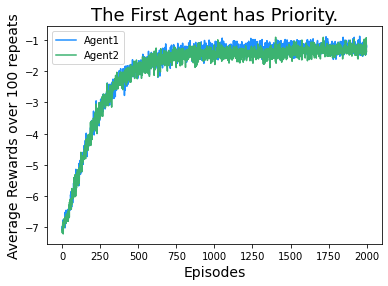

In [19]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(episode_reward_1, color = "dodgerblue")
ax.plot(episode_reward_2, color = "mediumseagreen")
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel(f"Average Rewards over {repeats} repeats",
              color = "black", fontsize = 14)
ax.set_title("The First Agent has Priority.", fontsize = 18)
plt.legend(['Agent1', 'Agent2'])
plt.show()

In [20]:
avg_diff = 0

for j in range(num_episodes):
    avg_diff += episode_reward_1[j] - episode_reward_2[j]
    
avg_diff = avg_diff / num_episodes

print(f"The structural difference caused by priority is {avg_diff}.")

The structural difference caused by priority is 0.08569449999999983.


Environment with random priority

In [21]:
class MAGridworld2(gym.Env):
    
    metadata = { 'render.modes': ['human', 'rgb_array'] }
    
    def __init__(self, size, num_agents):
        # the size of the Gridworld
        self.size = size
        self.observation_space = spaces.Box(low = 0,
                                            high = self.size,
                                            shape = (self.size,
                                                     self.size))
        # 5 types of actions: up, down, left, right, halt
        self.action_space = spaces.Discrete(5)
        # in case the horizontal and vertical lengths change..
        self._grid_size = (self.size, self.size)
        self.world = np.zeros((self._grid_size))
        # the interval between initial positions of players
        self.interval = int((self.size - 1) / (num_agents - 1))
        # the number of players in the game
        self.num_agents = num_agents
        self._timestep = None
        self._max_timestep = int(self.size * 4)
        self._step_cost = -0.1
        
    def reset(self):
        self.agent_pos = []
        self.goal_pos = []
        self._timestep = 0
        for i in range(self.num_agents):
            self.agent_pos.append([self.size - 1, i * self.interval])
            self.goal_pos.append([0, i * self.interval])
        self.done = [False] * self.num_agents
        self.goal_pos.reverse()
        observation = self.agent_pos
        return observation
    
    # to measure the distance between an agent's position and the goal
    def _compute_distance(self, x, y):
        dist = np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])
        return dist
    
    def _is_collision(self, new_pos, agent):
        for i in range(self.num_agents):
            if i == agent:
                continue
            elif new_pos == self.agent_pos[i]:
                return True
            elif new_pos == self.goal_pos[i]:
                return True
            
    def step(self, actions, temp_random):
        # Instantiate dones.
        self._timestep += 1
        old_pos = self.agent_pos.copy()
        # Instantiate rewards.
        rewards = [0] * self.num_agents
        # the next states and the rewards for each player
        
        if temp_random == 1:
            order = [0, 1]
        else:
            order = [1, 0]
        for agent in order:
            next_pos = copy(self.agent_pos[agent])
            # the next states
            if actions[agent] == 0: # down
                next_pos[0] += 1
            elif actions[agent] == 1: # up
                next_pos[0] -= 1
            elif actions[agent] == 2: # right
                next_pos[1] += 1
            elif actions[agent] == 3: # left
                next_pos[1] -= 1
            elif actions[agent] == 4: # halt
                pass
            else:
                raise Exception("The Action is not valid.")
            # for safety of the environment
            next_pos[0] = np.clip(next_pos[0], 0, self.size - 1)
            next_pos[1] = np.clip(next_pos[1], 0, self.size - 1)
            # First Come First Served.
            # The priority is given to the new position in the order of index.
            if not self._is_collision(next_pos, agent):
                self.agent_pos[agent] = next_pos
            else:
                pass 
            # the rewards
            old_dist = self._compute_distance(old_pos[agent],
                                              self.goal_pos[agent])
            new_dist = self._compute_distance(self.agent_pos[agent],
                                              self.goal_pos[agent])
            if new_dist == 0:
                self.done[agent] = True
                rewards[agent] = 1
            else:
                if new_dist < old_dist:
                    rewards[agent] = -0.1
                else:
                    rewards[agent] = -0.5

        if self._timestep >= self._max_timestep:
            self.done = [True] * self.num_agents    
        
        observation = self.agent_pos
        info = {}
        return observation, rewards, self.done, info
    
    def render(self):
        state = np.copy(self.world)
        for i in range(self.num_agents):
            state[tuple(self.agent_pos[i])] = 0.2 + 0.2 * i
            state[tuple(self.goal_pos[i])] = 1 - (0.2 * i)
        return plt.imshow(state)

Instantiate two agents.

In [22]:
env2 = MAGridworld2(size = size, num_agents = num_agents)
qlearning_agent1_c2 = QLearner(gamma = gamma,
                               num_states = num_states,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)
qlearning_agent2_c2 = QLearner(gamma = gamma,
                               num_states = num_states,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)

Checking fairness

In [23]:
repeats = 100
episode_reward_1 = [0] * num_episodes
episode_reward_2 = [0] * num_episodes
for repeat in range(repeats):
    print_every = 10
    qlearning_agent1_c2 = QLearner(gamma = gamma,
                               num_states = num_states,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)
    qlearning_agent2_c2 = QLearner(gamma = gamma,
                               num_states = num_states,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)

    for ep in range(num_episodes):
        states = [env2.reset()[0][0] * config['GRID_SIZE'] + env2.reset()[0][1],
                  env2.reset()[1][0] * config['GRID_SIZE'] + env2.reset()[1][1]]
        env2.reset()
        total_reward1 = 0
        total_reward2 = 0

        while True:
            # epsilon-greedy policy
            actions = [qlearning_agent1_c2.get_action(states[0]),
                       qlearning_agent2_c2.get_action(states[1])]
            temp_random = np.random.choice(2)
            _, rewards, dones, _ = env2.step(actions, temp_random)
            next_states = [env2.agent_pos[0][0] * config['GRID_SIZE'] + env2.agent_pos[0][1],
                           env2.agent_pos[1][0] * config['GRID_SIZE'] + env2.agent_pos[1][1]]

            # Q-learning: Update Q-table using greedy policy.
            qlearning_agent1_c2.update_sample(state = states[0],
                                              action = actions[0],
                                              reward = rewards[0],
                                              next_state = next_states[0],
                                              done = dones[0])
            qlearning_agent2_c2.update_sample(state = states[1],
                                              action = actions[1],
                                              reward = rewards[1],
                                              next_state = next_states[1],
                                              done = dones[1])

            total_reward1 += rewards[0]
            total_reward2 += rewards[1]

            states = next_states

            if dones[0] or dones[1]:
                break

        qlearning_agent1_c2.eps *= factor
        qlearning_agent2_c2.eps *= factor

        episode_reward_1[ep] += total_reward1
        episode_reward_2[ep] += total_reward2
        
    if repeat % print_every == 9:
        print(f"The {repeat + 1}th repeat has been processed.")
    
for j in range(num_episodes):
    episode_reward_1[j] = episode_reward_1[j] / repeats
    episode_reward_2[j] = episode_reward_2[j] / repeats

The 10th repeat has been processed.
The 20th repeat has been processed.
The 30th repeat has been processed.
The 40th repeat has been processed.
The 50th repeat has been processed.
The 60th repeat has been processed.
The 70th repeat has been processed.
The 80th repeat has been processed.
The 90th repeat has been processed.
The 100th repeat has been processed.


Visualization
- No player has a significant structural advantage over another agent in the middle of training.
- The figure is from the results of training with 2000 episodes over 100 repeats.

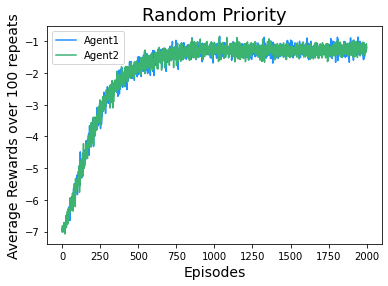

In [24]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(episode_reward_1, color = "dodgerblue")
ax.plot(episode_reward_2, color = "mediumseagreen")
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel(f"Average Rewards over {repeats} repeats",
              color = "black", fontsize = 14)
ax.set_title("Random Priority", fontsize = 18)
plt.legend(['Agent1', 'Agent2'])
plt.show()

In [25]:
avg_diff = 0

for j in range(num_episodes):
    avg_diff += episode_reward_1[j] - episode_reward_2[j]
    
avg_diff = avg_diff / num_episodes

print(f"The structural difference without priority is {avg_diff}.")

The structural difference without priority is 0.0030695000000000227.


Greedy Policy

Step 1


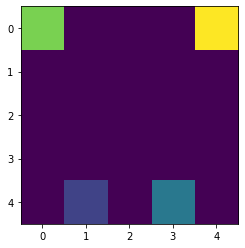

Step 2


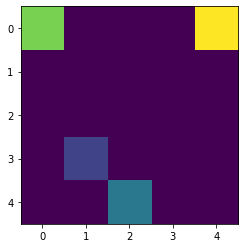

Step 3


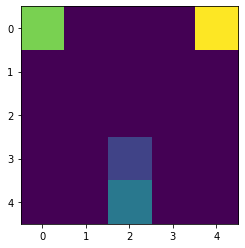

Step 4


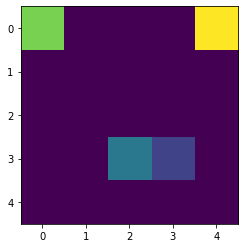

Step 5


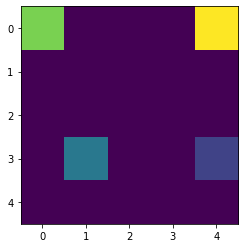

Step 6


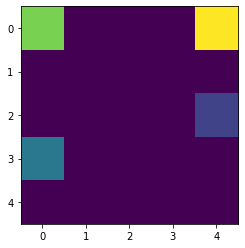

Step 7


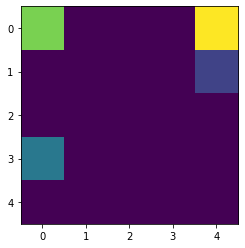

Step 8


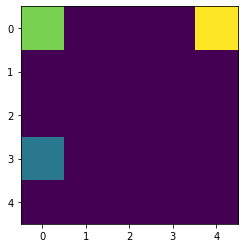

In [26]:
env2.reset()
states = [env2.reset()[0][0] * config['GRID_SIZE'] + env2.reset()[0][1],
          env2.reset()[1][0] * config['GRID_SIZE'] + env2.reset()[1][1]]

# Only carry out the optimal policy trained via Q-learning.
qlearning_agent1_c2.eps = 0.0
qlearning_agent2_c2.eps = 0.0
count = 0

while True:
    actions = [qlearning_agent1_c2.get_action(states[0]),
               qlearning_agent2_c2.get_action(states[1])]
    temp_random = np.random.choice(2)
    _, rewards, dones, _ = env2.step(actions, temp_random)
    next_states = [env2.agent_pos[0][0] * config['GRID_SIZE'] + env2.agent_pos[0][1],
                   env2.agent_pos[1][0] * config['GRID_SIZE'] + env2.agent_pos[1][1]]
    states = next_states
    count += 1

    print(f"Step {count}")
    env2.render()
    plt.show()
    time.sleep(1)
    
    if dones[0] + dones[1] > 0:
        break

Step 1


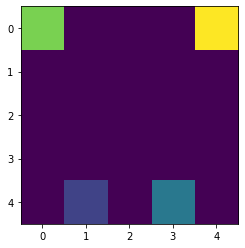

Step 2


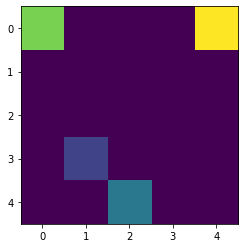

Step 3


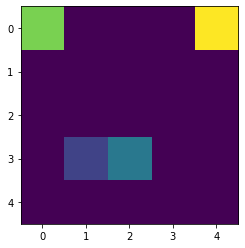

Step 4


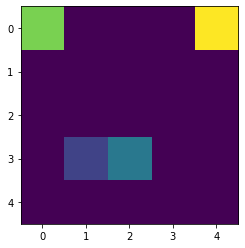

Step 5


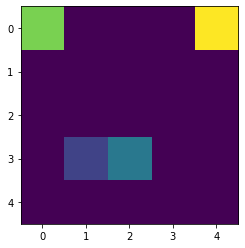

Step 6


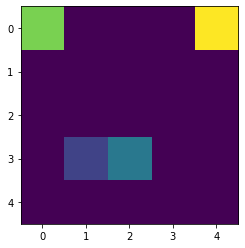

Step 7


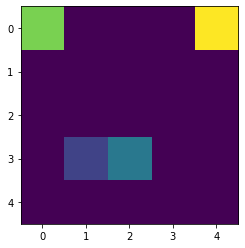

Step 8


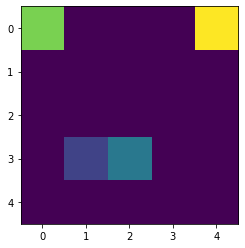

Step 9


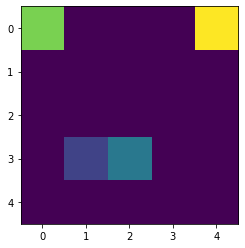

Step 10


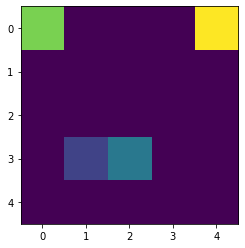

Step 11


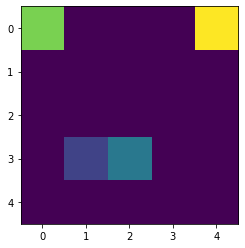

Step 12


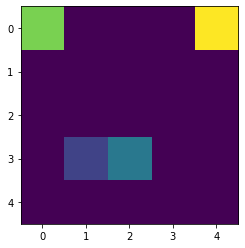

Step 13


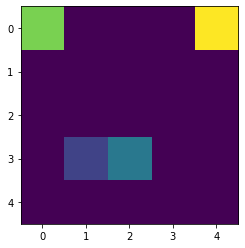

Step 14


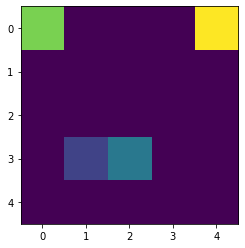

Step 15


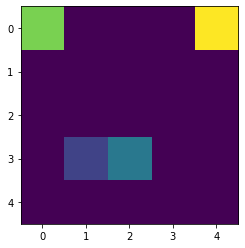

Step 16


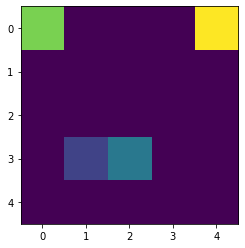

Step 17


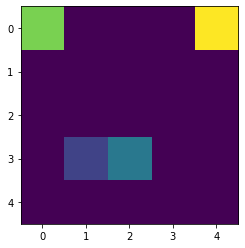

Step 18


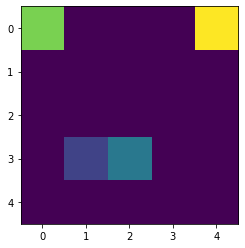

Step 19


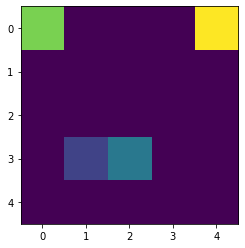

Step 20


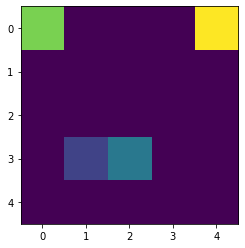

In [27]:
env2.reset()
states = [env2.reset()[0][0] * config['GRID_SIZE'] + env2.reset()[0][1],
          env2.reset()[1][0] * config['GRID_SIZE'] + env2.reset()[1][1]]

# Only carry out the optimal policy trained via Q-learning.
qlearning_agent1_c2.eps = 0.0
qlearning_agent2_c2.eps = 0.0
count = 0

while True:
    actions = [qlearning_agent1_c2.get_action(states[0]),
               qlearning_agent2_c2.get_action(states[1])]
    temp_random = 0 # The first agent has priority.
    _, rewards, dones, _ = env2.step(actions, temp_random)
    next_states = [env2.agent_pos[0][0] * config['GRID_SIZE'] + env2.agent_pos[0][1],
                   env2.agent_pos[1][0] * config['GRID_SIZE'] + env2.agent_pos[1][1]]
    states = next_states
    count += 1

    print(f"Step {count}")
    env2.render()
    plt.show()
    time.sleep(1)
    
    if dones[0] + dones[1] > 0:
        break

Step 1


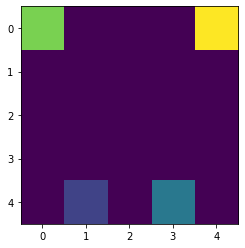

Step 2


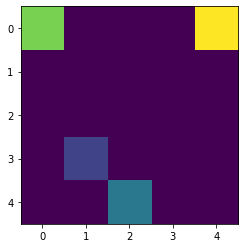

Step 3


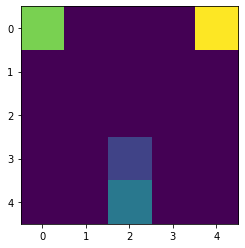

Step 4


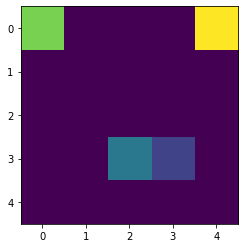

Step 5


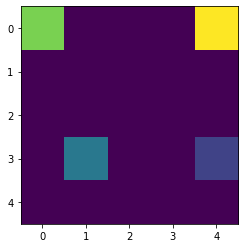

Step 6


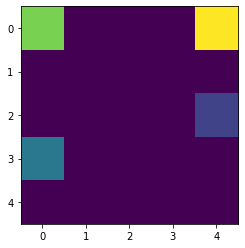

Step 7


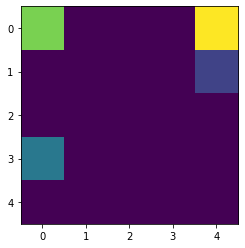

Step 8


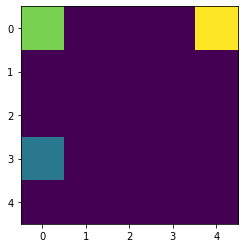

In [28]:
env2.reset()
states = [env2.reset()[0][0] * config['GRID_SIZE'] + env2.reset()[0][1],
          env2.reset()[1][0] * config['GRID_SIZE'] + env2.reset()[1][1]]

# Only carry out the optimal policy trained via Q-learning.
qlearning_agent1_c2.eps = 0.0
qlearning_agent2_c2.eps = 0.0
count = 0

while True:
    actions = [qlearning_agent1_c2.get_action(states[0]),
               qlearning_agent2_c2.get_action(states[1])]
    temp_random = 1 # The second agent has the priority.
    _, rewards, dones, _ = env2.step(actions, temp_random)
    next_states = [env2.agent_pos[0][0] * config['GRID_SIZE'] + env2.agent_pos[0][1],
                   env2.agent_pos[1][0] * config['GRID_SIZE'] + env2.agent_pos[1][1]]
    states = next_states
    count += 1

    print(f"Step {count}")
    env2.render()
    plt.show()
    time.sleep(1)
    
    if dones[0] + dones[1] > 0:
        break

Now two players always successfully arrive at their destination within the optimal number of steps.

## Part 3 What if the number of agents is more than two?
---

Environment with random priority (four agents)

In [29]:
class MAGridworld3(gym.Env):
    
    metadata = { 'render.modes': ['human', 'rgb_array'] }
    
    def __init__(self, size, num_agents):
        # the size of the Gridworld
        self.size = size
        self.observation_space = spaces.Box(low = 0,
                                            high = self.size,
                                            shape = (self.size,
                                                     self.size))
        # 5 types of actions: up, down, left, right, halt
        self.action_space = spaces.Discrete(5)
        # in case the horizontal and vertical lengths change..
        self._grid_size = (self.size, self.size)
        self.world = np.zeros((self._grid_size))
        # the interval between initial positions of players
        self.interval = int((self.size - 1) / (num_agents - 1))
        # the number of players in the game
        self.num_agents = num_agents
        self._timestep = None
        self._max_timestep = int(self.size * 4)
        self._step_cost = -0.1
        
    def reset(self):
        self.agent_pos = []
        self.goal_pos = []
        self._timestep = 0
        for i in range(self.num_agents):
            self.agent_pos.append([self.size - 1, i * self.interval])
            self.goal_pos.append([0, i * self.interval])
        self.done = [False] * self.num_agents
        self.goal_pos.reverse()
        observation = self.agent_pos
        return observation
    
    # to measure the distance between an agent's position and the goal
    def _compute_distance(self, x, y):
        dist = np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])
        return dist
    
    def _is_collision(self, new_pos, agent):
        for i in range(self.num_agents):
            if i == agent:
                continue
            elif new_pos == self.agent_pos[i]:
                return True
            elif new_pos == self.goal_pos[i]:
                return True
            
    def step(self, actions, temp_random):
        # Instantiate dones.
        self._timestep += 1
        old_pos = self.agent_pos.copy()
        # Instantiate rewards.
        rewards = [0] * self.num_agents
        # the next states and the rewards for each player
        
        if temp_random == 0:
            order = [0, 1, 2, 3]
        elif temp_random == 1:    
            order = [0, 1, 3, 2]
        elif temp_random == 2:    
            order = [0, 2, 1, 3]
        elif temp_random == 3:    
            order = [0, 2, 3, 1]
        elif temp_random == 4:    
            order = [0, 3, 1, 2]
        elif temp_random == 5:    
            order = [0, 3, 2, 1]
        elif temp_random == 6:    
            order = [1, 0, 2, 3]
        elif temp_random == 7:    
            order = [1, 0, 3, 2]
        elif temp_random == 8:    
            order = [1, 2, 0, 3]
        elif temp_random == 9:    
            order = [1, 2, 3, 0]
        elif temp_random == 10:    
            order = [1, 3, 0, 2]
        elif temp_random == 11:    
            order = [1, 3, 2, 0]
        elif temp_random == 12:    
            order = [2, 0, 1, 3]
        elif temp_random == 13:    
            order = [2, 0, 3, 1]
        elif temp_random == 14:    
            order = [2, 1, 0, 3]
        elif temp_random == 15:    
            order = [2, 1, 3, 0]
        elif temp_random == 16:    
            order = [2, 3, 0, 1]
        elif temp_random == 17:    
            order = [2, 3, 1, 0]
        elif temp_random == 18:    
            order = [3, 0, 1, 2]
        elif temp_random == 19:    
            order = [3, 0, 2, 1]
        elif temp_random == 20:    
            order = [3, 1, 0, 2]
        elif temp_random == 21:    
            order = [3, 1, 2, 0]
        elif temp_random == 22:    
            order = [3, 2, 0, 1]
        else:    
            order = [3, 2, 1, 0]
            
        for agent in order:
            next_pos = copy(self.agent_pos[agent])
            # the next states
            if actions[agent] == 0: # down
                next_pos[0] += 1
            elif actions[agent] == 1: # up
                next_pos[0] -= 1
            elif actions[agent] == 2: # right
                next_pos[1] += 1
            elif actions[agent] == 3: # left
                next_pos[1] -= 1
            elif actions[agent] == 4: # halt
                pass
            else:
                raise Exception("The Action is not valid.")
            # for safety of the environment
            next_pos[0] = np.clip(next_pos[0], 0, self.size - 1)
            next_pos[1] = np.clip(next_pos[1], 0, self.size - 1)
            # First Come First Served.
            # The priority is given to the new position in the order of index.
            if not self._is_collision(next_pos, agent):
                self.agent_pos[agent] = next_pos
            else:
                pass 
            # the rewards
            old_dist = self._compute_distance(old_pos[agent],
                                              self.goal_pos[agent])
            new_dist = self._compute_distance(self.agent_pos[agent],
                                              self.goal_pos[agent])
            if new_dist == 0:
                self.done[agent] = True
                rewards[agent] = 1
            else:
                if new_dist < old_dist:
                    rewards[agent] = -0.1
                else:
                    rewards[agent] = -0.5

        if self._timestep >= self._max_timestep:
            self.done = [True] * self.num_agents    
        
        observation = self.agent_pos
        info = {}
        return observation, rewards, self.done, info
    
    def render(self):
        state = np.copy(self.world)
        for i in range(self.num_agents):
            state[tuple(self.agent_pos[i])] = 0.2 + 0.2 * i
            state[tuple(self.goal_pos[i])] = 1 - (0.2 * i)
        return plt.imshow(state)

Four Agents

In [30]:
config3 = {
    'NUM_AGENTS': 4,
    'GRID_SIZE': 13 # As the number of agents increase, widen the environment.
}

Instantiate three agents.

In [31]:
size3 = config3['GRID_SIZE']
env3 = MAGridworld3(size = size3, num_agents = config3['NUM_AGENTS'])
num_states3 = env3.observation_space.shape[0] * env3.observation_space.shape[1]
qlearning_agent1_c3 = QLearner(gamma = gamma,
                               num_states = num_states3,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)
qlearning_agent2_c3 = QLearner(gamma = gamma,
                               num_states = num_states3,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)
qlearning_agent3_c3 = QLearner(gamma = gamma,
                               num_states = num_states3,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)
qlearning_agent4_c3 = QLearner(gamma = gamma,
                               num_states = num_states3,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)

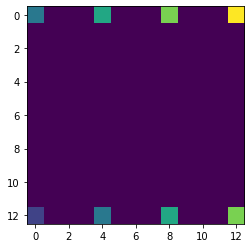

In [32]:
env3.reset()
env3.render()

States:	  [[11, 0], [11, 4], [11, 8], [11, 12]]
Rewards:  [-0.1, -0.1, -0.1, -0.1]
dones:	  [False, False, False, False]


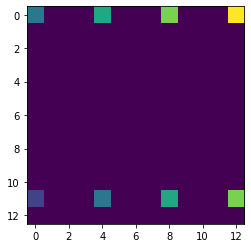

In [33]:
if __name__ == '__main__':
    num_agents3 = config3['NUM_AGENTS']
    size3 = config3['GRID_SIZE']
    env3 = MAGridworld3(size = size3, num_agents = num_agents3)
    env3.reset()
    env3.render()
    action_n = [1, 1, 1, 1]
    temp_random = np.random.choice(24)
    state, reward, done, _ = env3.step(action_n, temp_random)
    print('States:\t ', state)
    print('Rewards: ', reward)
    print('dones:\t ', done)
    env3.render()

States:	  [[10, 0], [10, 4], [10, 8], [10, 12]]
Rewards:  [-0.1, -0.1, -0.1, -0.1]
dones:	  [False, False, False, False]


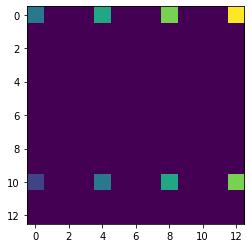

In [34]:
action_n = [1, 1, 1, 1]
temp_random = np.random.choice(24)
next_state, reward, done, _ = env3.step(action_n, temp_random)
print('States:\t ', next_state)
print('Rewards: ', reward)
print('dones:\t ', done)
env3.render()

Checking fairness

In [35]:
repeats = 50
episode_reward_1 = [0] * 4000
episode_reward_2 = [0] * 4000
episode_reward_3 = [0] * 4000
episode_reward_4 = [0] * 4000
factor = (1e-2)**(1 / 4000)

for repeat in range(repeats):
    print_every = 10
    qlearning_agent1_c3 = QLearner(gamma = gamma,
                               num_states = num_states3,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)
    qlearning_agent2_c3 = QLearner(gamma = gamma,
                               num_states = num_states3,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)
    qlearning_agent3_c3 = QLearner(gamma = gamma,
                               num_states = num_states3,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)
    qlearning_agent4_c3 = QLearner(gamma = gamma,
                               num_states = num_states3,
                               num_actions = num_actions,
                               eps = eps,
                               lr = lr)

    for ep in range(4000):
        states = [env3.reset()[0][0] * config3['GRID_SIZE'] + env3.reset()[0][1],
                  env3.reset()[1][0] * config3['GRID_SIZE'] + env3.reset()[1][1],
                  env3.reset()[2][0] * config3['GRID_SIZE'] + env3.reset()[2][1],
                  env3.reset()[3][0] * config3['GRID_SIZE'] + env3.reset()[3][1]]
        env3.reset()
        total_reward1 = 0
        total_reward2 = 0
        total_reward3 = 0
        total_reward4 = 0

        while True:
            # epsilon-greedy policy
            actions = [qlearning_agent1_c3.get_action(states[0]),
                       qlearning_agent2_c3.get_action(states[1]),
                       qlearning_agent3_c3.get_action(states[2]),
                       qlearning_agent4_c3.get_action(states[3])]
            temp_random = np.random.choice(24)
            _, rewards, dones, _ = env3.step(actions, temp_random)
            next_states = [env3.agent_pos[0][0] * config3['GRID_SIZE'] + env3.agent_pos[0][1],
                           env3.agent_pos[1][0] * config3['GRID_SIZE'] + env3.agent_pos[1][1],
                           env3.agent_pos[2][0] * config3['GRID_SIZE'] + env3.agent_pos[2][1],
                           env3.agent_pos[3][0] * config3['GRID_SIZE'] + env3.agent_pos[3][1]]

            # Q-learning: Update Q-table using greedy policy.
            qlearning_agent1_c3.update_sample(state = states[0],
                                           action = actions[0],
                                           reward = rewards[0],
                                           next_state = next_states[0],
                                           done = dones[0])
            qlearning_agent2_c3.update_sample(state = states[1],
                                           action = actions[1],
                                           reward = rewards[1],
                                           next_state = next_states[1],
                                           done = dones[1])
            qlearning_agent3_c3.update_sample(state = states[2],
                                           action = actions[2],
                                           reward = rewards[2],
                                           next_state = next_states[2],
                                           done = dones[2])
            qlearning_agent4_c3.update_sample(state = states[3],
                                           action = actions[3],
                                           reward = rewards[3],
                                           next_state = next_states[3],
                                           done = dones[3])

            total_reward1 += rewards[0]
            total_reward2 += rewards[1]
            total_reward3 += rewards[2]
            total_reward4 += rewards[3]

            states = next_states

            if dones[0] or dones[1] or dones[2] or dones[3]:
                break

        qlearning_agent1_c3.eps *= factor
        qlearning_agent2_c3.eps *= factor
        qlearning_agent3_c3.eps *= factor
        qlearning_agent4_c3.eps *= factor

        episode_reward_1[ep] += total_reward1
        episode_reward_2[ep] += total_reward2
        episode_reward_3[ep] += total_reward3
        episode_reward_4[ep] += total_reward4
        
    if repeat % print_every == 9:
        print(f"The {repeat + 1}th repeat has been processed.")
    
for j in range(4000):
    episode_reward_1[j] = episode_reward_1[j] / repeats
    episode_reward_2[j] = episode_reward_2[j] / repeats
    episode_reward_3[j] = episode_reward_3[j] / repeats
    episode_reward_4[j] = episode_reward_4[j] / repeats

The 10th repeat has been processed.
The 20th repeat has been processed.
The 30th repeat has been processed.
The 40th repeat has been processed.
The 50th repeat has been processed.


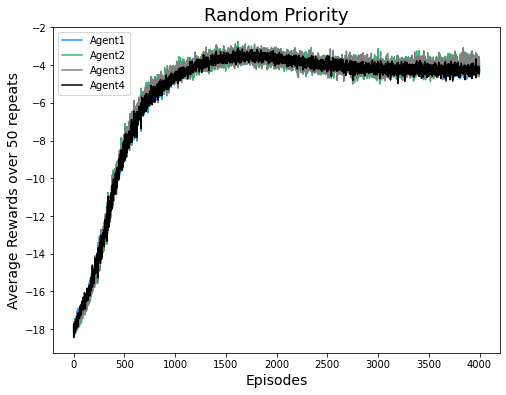

In [36]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(episode_reward_1, color = "dodgerblue")
ax.plot(episode_reward_2, color = "mediumseagreen")
ax.plot(episode_reward_3, color = "grey")
ax.plot(episode_reward_4, color = "black")
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel(f"Average Rewards over {repeats} repeats",
              color = "black", fontsize = 14)
ax.set_title("Random Priority", fontsize = 18)
plt.legend(['Agent1', 'Agent2', 'Agent3', 'Agent4'])
plt.show()

Training agents in the environment with random priority

In [37]:
start = time.time()

qlearning_rewards1 = []
qlearning_rewards2 = []
qlearning_rewards3 = []
qlearning_rewards4 = []
eps_values = []
print_every = 500
factor = (1e-2)**(1 / 4000)

qlearning_agent1_4 = QLearner(gamma = gamma,
                              num_states = num_states3,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)
qlearning_agent2_4 = QLearner(gamma = gamma,
                              num_states = num_states3,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)
qlearning_agent3_4 = QLearner(gamma = gamma,
                              num_states = num_states3,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)
qlearning_agent4_4 = QLearner(gamma = gamma,
                              num_states = num_states3,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)

for ep in range(4000):
    states = [env3.reset()[0][0] * config3['GRID_SIZE'] + env3.reset()[0][1],
              env3.reset()[1][0] * config3['GRID_SIZE'] + env3.reset()[1][1],
              env3.reset()[2][0] * config3['GRID_SIZE'] + env3.reset()[2][1],
              env3.reset()[3][0] * config3['GRID_SIZE'] + env3.reset()[3][1]]
    env3.reset()
    total_reward1 = 0
    total_reward2 = 0
    total_reward3 = 0
    total_reward4 = 0
    
    while True:
        # epsilon-greedy policy
        actions = [qlearning_agent1_4.get_action(states[0]),
                   qlearning_agent2_4.get_action(states[1]),
                   qlearning_agent3_4.get_action(states[2]),
                   qlearning_agent4_4.get_action(states[3])]
        temp_random = np.random.choice(24)
        _, rewards, dones, _ = env3.step(actions, temp_random)
        next_states = [env3.agent_pos[0][0] * config3['GRID_SIZE'] + env3.agent_pos[0][1],
                       env3.agent_pos[1][0] * config3['GRID_SIZE'] + env3.agent_pos[1][1],
                       env3.agent_pos[2][0] * config3['GRID_SIZE'] + env3.agent_pos[2][1],
                       env3.agent_pos[3][0] * config3['GRID_SIZE'] + env3.agent_pos[3][1]]
        
        # Q-learning: Update Q-table using greedy policy.
        qlearning_agent1_4.update_sample(state = states[0],
                                         action = actions[0],
                                         reward = rewards[0],
                                         next_state = next_states[0],
                                         done = dones[0])
        qlearning_agent2_4.update_sample(state = states[1],
                                         action = actions[1],
                                         reward = rewards[1],
                                         next_state = next_states[1],
                                         done = dones[1])
        qlearning_agent3_4.update_sample(state = states[2],
                                         action = actions[2],
                                         reward = rewards[2],
                                         next_state = next_states[2],
                                         done = dones[2])
        qlearning_agent4_4.update_sample(state = states[3],
                                         action = actions[3],
                                         reward = rewards[3],
                                         next_state = next_states[3],
                                         done = dones[3])
        
        total_reward1 += rewards[0]
        total_reward2 += rewards[1]
        total_reward3 += rewards[2]
        total_reward4 += rewards[3]
        
        states = next_states
        
        if dones[0] or dones[1] or dones[2] or dones[3]:
            break
            
    qlearning_rewards1.append(total_reward1)
    qlearning_rewards2.append(total_reward2)
    qlearning_rewards3.append(total_reward3)
    qlearning_rewards4.append(total_reward4)
    
    eps_values.append(qlearning_agent1_4.eps)
    
    qlearning_agent1_4.eps *= factor
    qlearning_agent2_4.eps *= factor
    qlearning_agent3_4.eps *= factor
    qlearning_agent4_4.eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {qlearning_agent1_4.eps:.2f}")
        
end = time.time()
print(f"For 4 agents, the elapsed time: {round(end - start, 1)} seconds")

Episode: 500	| Epsilon: 0.56
Episode: 1000	| Epsilon: 0.32
Episode: 1500	| Epsilon: 0.18
Episode: 2000	| Epsilon: 0.10
Episode: 2500	| Epsilon: 0.06
Episode: 3000	| Epsilon: 0.03
Episode: 3500	| Epsilon: 0.02
Episode: 4000	| Epsilon: 0.01
For 4 agents, the elapsed time: 20.3 seconds


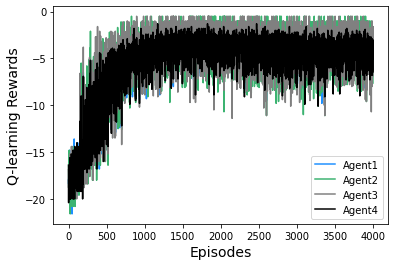

In [38]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(qlearning_rewards1, color = "dodgerblue")
ax.plot(qlearning_rewards2, color = "mediumseagreen")
ax.plot(qlearning_rewards3, color = "grey")
ax.plot(qlearning_rewards4, color = "black")
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Q-learning Rewards", color = "black", fontsize = 14)
plt.legend(['Agent1', 'Agent2', 'Agent3', 'Agent4'], loc = "lower right")
plt.show()

Greedy Policy

Step 1


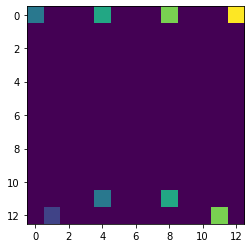

Step 2


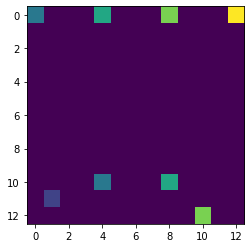

Step 3


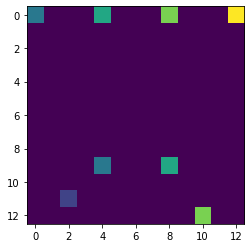

Step 4


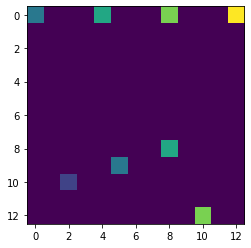

Step 5


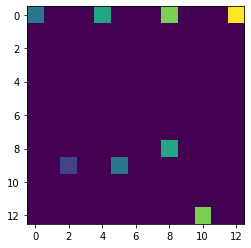

Step 6


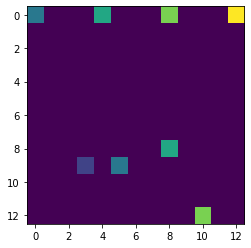

Step 7


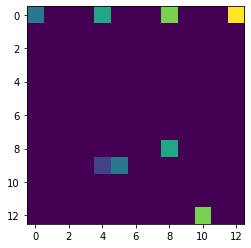

Step 8


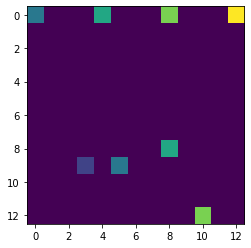

Step 9


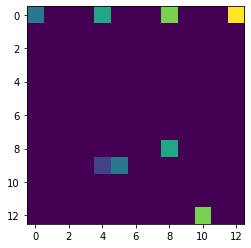

Step 10


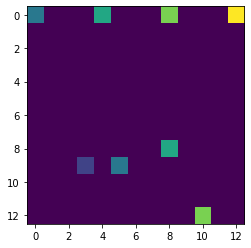

Step 11


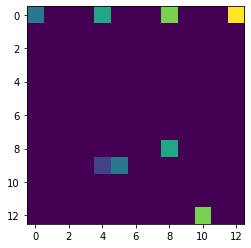

Step 12


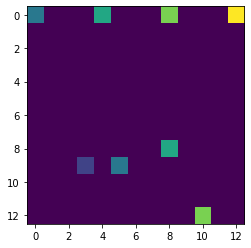

Step 13


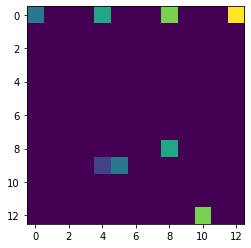

Step 14


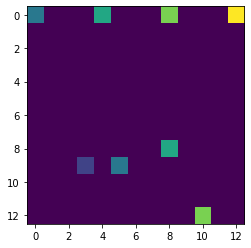

Step 15


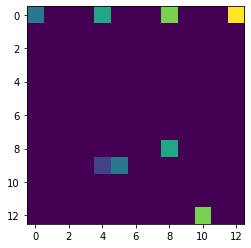

Step 16


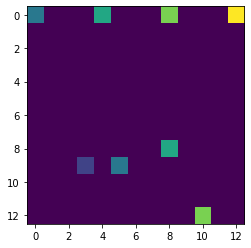

Step 17


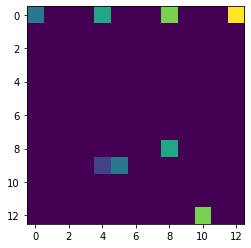

Step 18


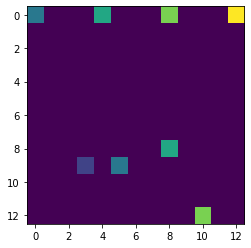

Step 19


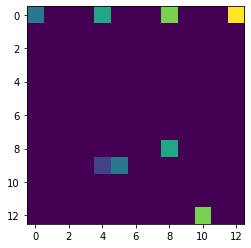

Step 20


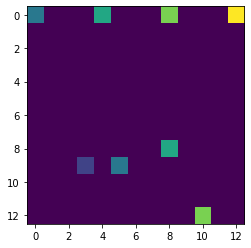

Step 21


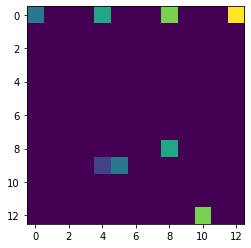

Step 22


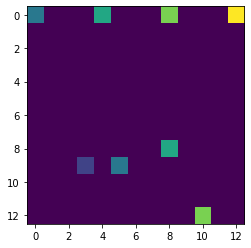

Step 23


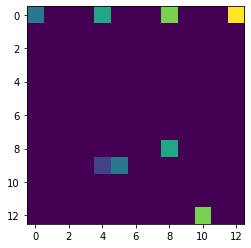

Step 24


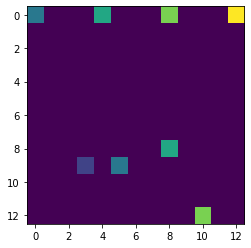

Step 25


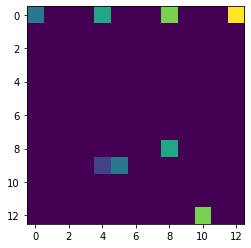

Step 26


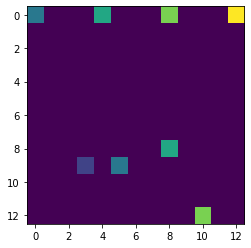

Step 27


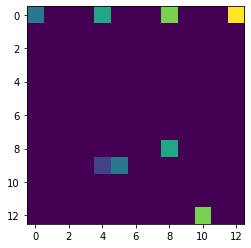

Step 28


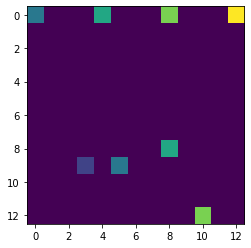

Step 29


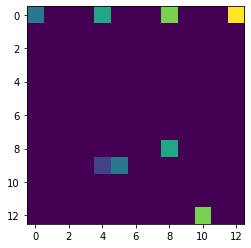

Step 30


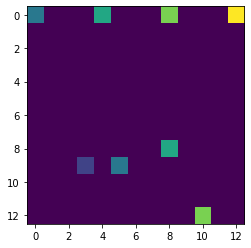

Step 31


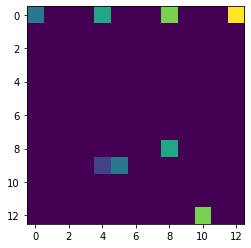

Step 32


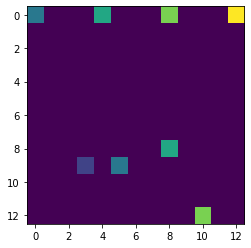

Step 33


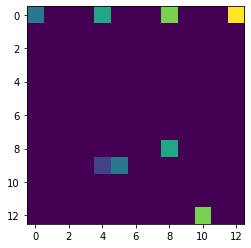

Step 34


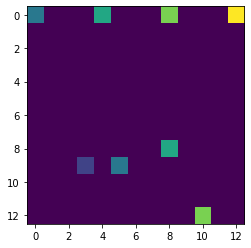

Step 35


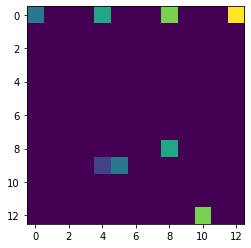

Step 36


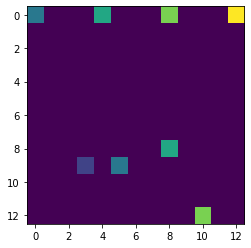

Step 37


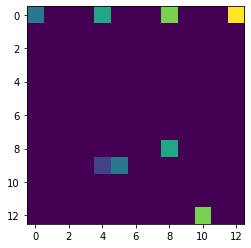

Step 38


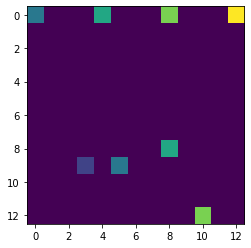

Step 39


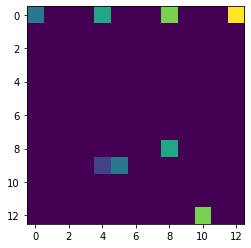

Step 40


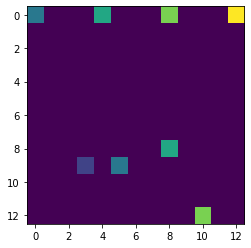

Step 41


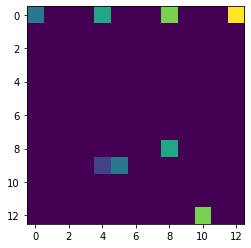

Step 42


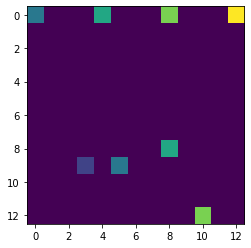

Step 43


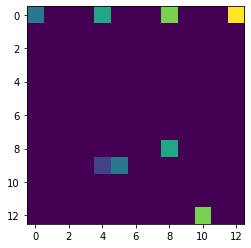

Step 44


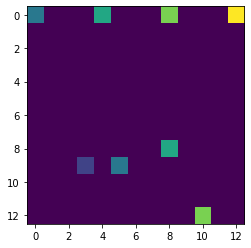

Step 45


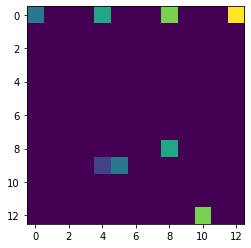

Step 46


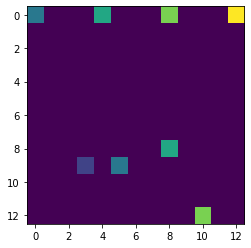

Step 47


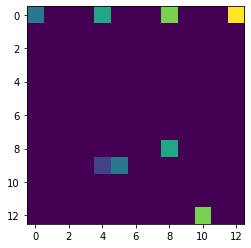

Step 48


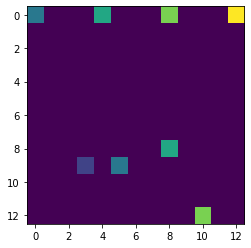

Step 49


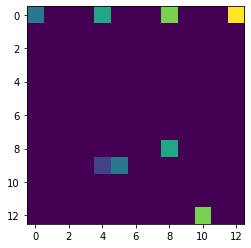

Step 50


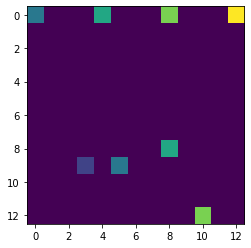

Step 51


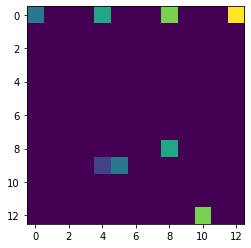

Step 52


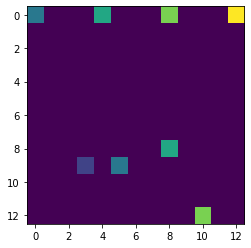

In [39]:
env3.reset()
states = [env3.reset()[0][0] * config3['GRID_SIZE'] + env3.reset()[0][1],
          env3.reset()[1][0] * config3['GRID_SIZE'] + env3.reset()[1][1],
          env3.reset()[2][0] * config3['GRID_SIZE'] + env3.reset()[2][1],
          env3.reset()[3][0] * config3['GRID_SIZE'] + env3.reset()[3][1]]

# Only carry out the optimal policy trained via Q-learning.
qlearning_agent1_4.eps = 0.0
qlearning_agent2_4.eps = 0.0
qlearning_agent3_4.eps = 0.0
qlearning_agent4_4.eps = 0.0
count = 0

while True:
    actions = [qlearning_agent1_4.get_action(states[0]),
               qlearning_agent2_4.get_action(states[1]),
               qlearning_agent3_4.get_action(states[2]),
               qlearning_agent4_4.get_action(states[3])]
    temp_random = np.random.choice(24)
    _, rewards, dones, _ = env3.step(actions, temp_random)
    next_states = [env3.agent_pos[0][0] * config3['GRID_SIZE'] + env3.agent_pos[0][1],
                   env3.agent_pos[1][0] * config3['GRID_SIZE'] + env3.agent_pos[1][1],
                   env3.agent_pos[2][0] * config3['GRID_SIZE'] + env3.agent_pos[2][1],
                   env3.agent_pos[3][0] * config3['GRID_SIZE'] + env3.agent_pos[3][1]]
    states = next_states
    count += 1

    print(f"Step {count}")
    env3.render()
    plt.show()
    time.sleep(1)
    
    if dones[0] + dones[1] + dones[2] + dones[3] > 0:
        break

Step 1


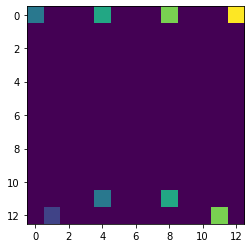

Step 2


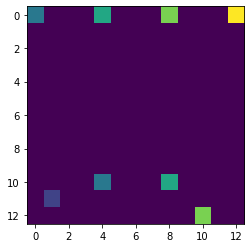

Step 3


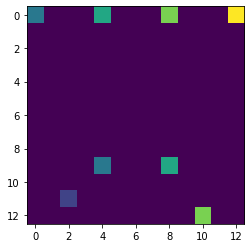

Step 4


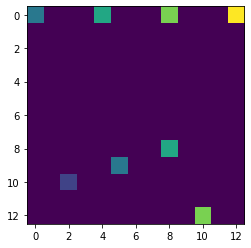

Step 5


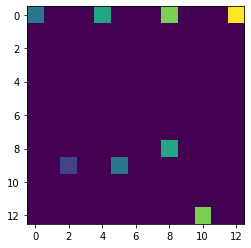

Step 6


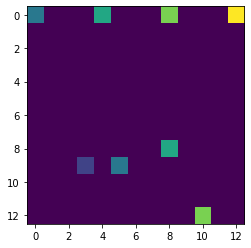

Step 7


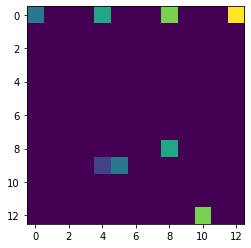

Step 8


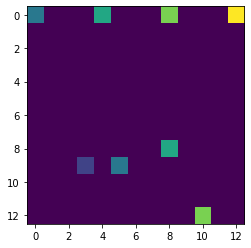

Step 9


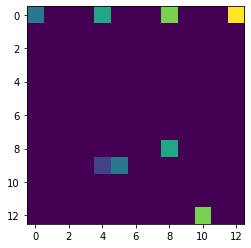

Step 10


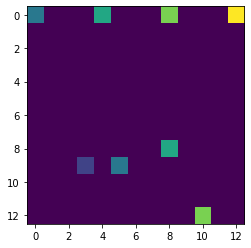

Step 11


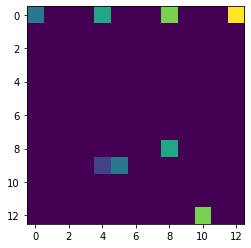

Step 12


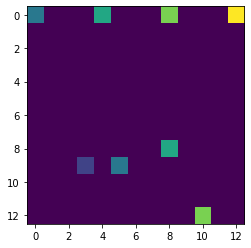

Step 13


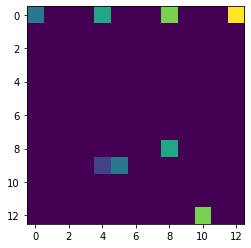

Step 14


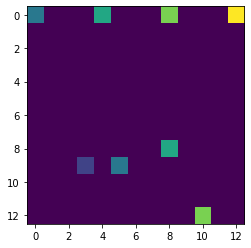

Step 15


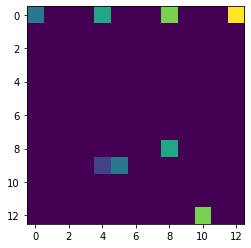

Step 16


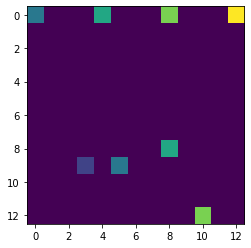

Step 17


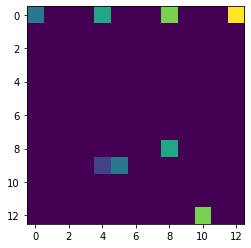

Step 18


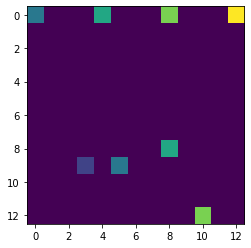

Step 19


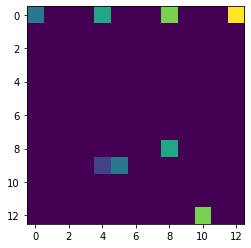

Step 20


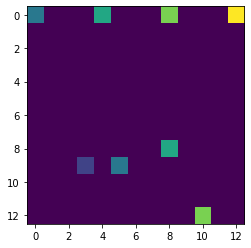

Step 21


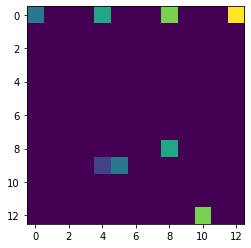

Step 22


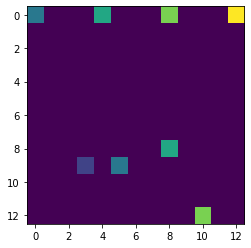

Step 23


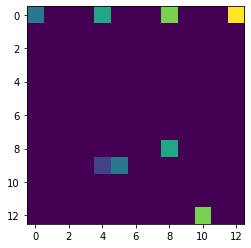

Step 24


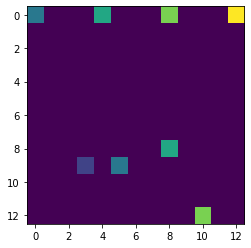

Step 25


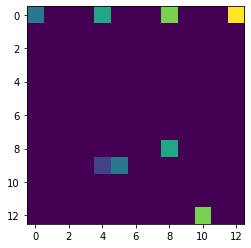

Step 26


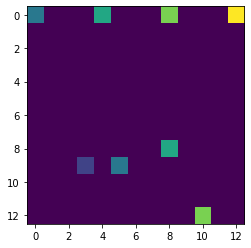

Step 27


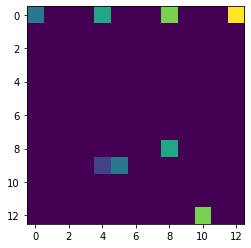

Step 28


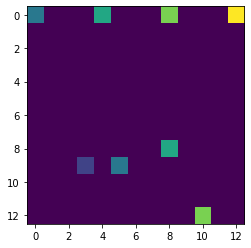

Step 29


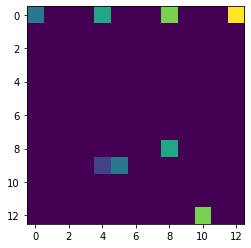

Step 30


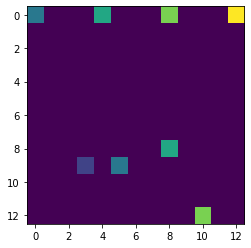

Step 31


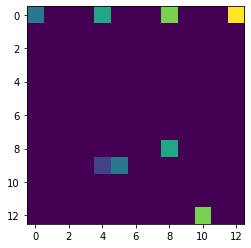

Step 32


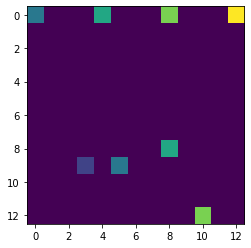

Step 33


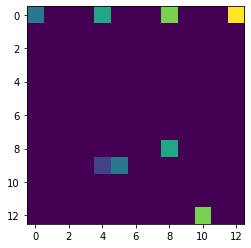

Step 34


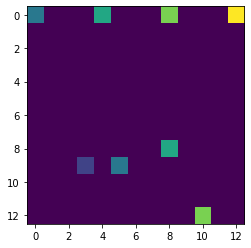

Step 35


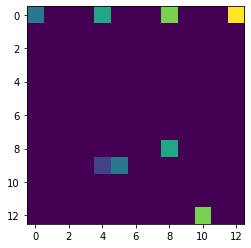

Step 36


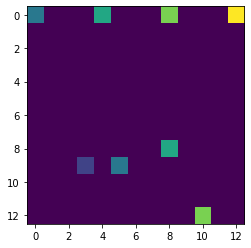

Step 37


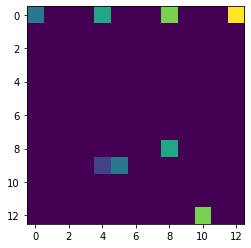

Step 38


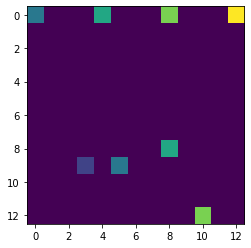

Step 39


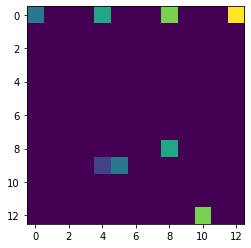

Step 40


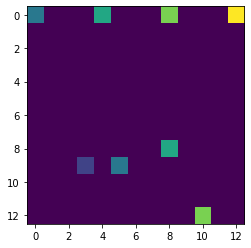

Step 41


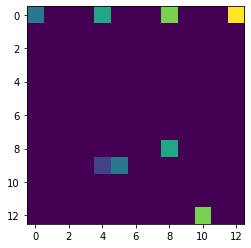

Step 42


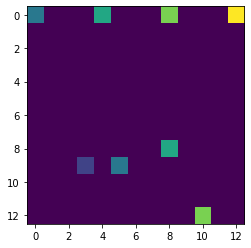

Step 43


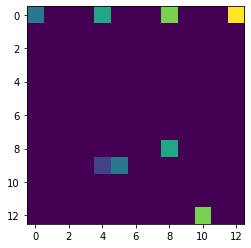

Step 44


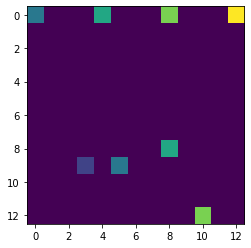

Step 45


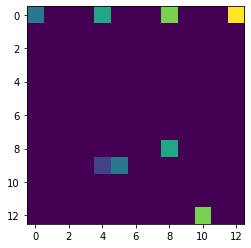

Step 46


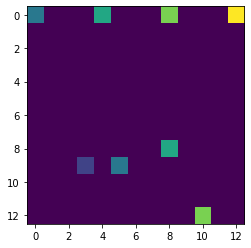

Step 47


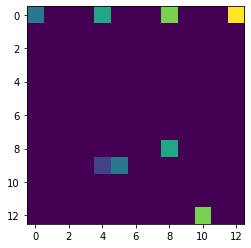

Step 48


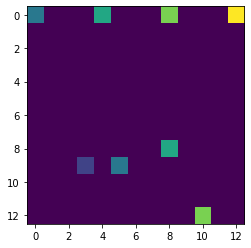

Step 49


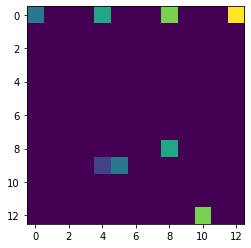

Step 50


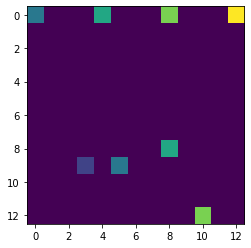

Step 51


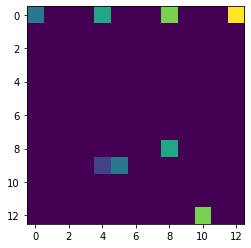

Step 52


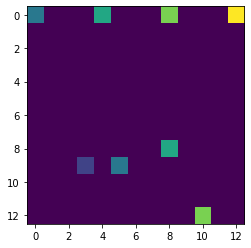

In [40]:
env3.reset()
states = [env3.reset()[0][0] * config3['GRID_SIZE'] + env3.reset()[0][1],
          env3.reset()[1][0] * config3['GRID_SIZE'] + env3.reset()[1][1],
          env3.reset()[2][0] * config3['GRID_SIZE'] + env3.reset()[2][1],
          env3.reset()[3][0] * config3['GRID_SIZE'] + env3.reset()[3][1]]

# Only carry out the optimal policy trained via Q-learning.
qlearning_agent1_4.eps = 0.0
qlearning_agent2_4.eps = 0.0
qlearning_agent3_4.eps = 0.0
qlearning_agent4_4.eps = 0.0
count = 0

while True:
    actions = [qlearning_agent1_4.get_action(states[0]),
               qlearning_agent2_4.get_action(states[1]),
               qlearning_agent3_4.get_action(states[2]),
               qlearning_agent4_4.get_action(states[3])]
    temp_random = 12 # the third agent has priority
    _, rewards, dones, _ = env3.step(actions, temp_random)
    next_states = [env3.agent_pos[0][0] * config3['GRID_SIZE'] + env3.agent_pos[0][1],
                   env3.agent_pos[1][0] * config3['GRID_SIZE'] + env3.agent_pos[1][1],
                   env3.agent_pos[2][0] * config3['GRID_SIZE'] + env3.agent_pos[2][1],
                   env3.agent_pos[3][0] * config3['GRID_SIZE'] + env3.agent_pos[3][1]]
    states = next_states
    count += 1

    print(f"Step {count}")
    env3.render()
    plt.show()
    time.sleep(1)
    
    if dones[0] + dones[1] + dones[2] + dones[3] > 0:
        break

Step 1


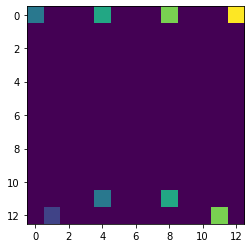

Step 2


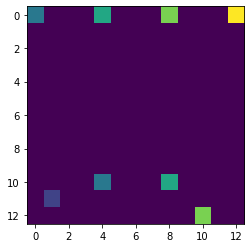

Step 3


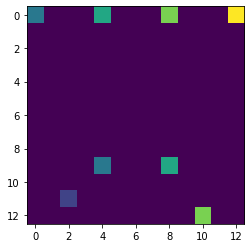

Step 4


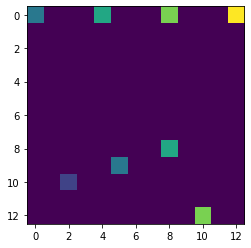

Step 5


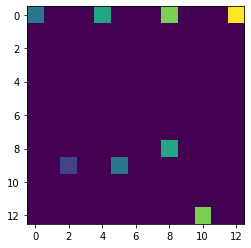

Step 6


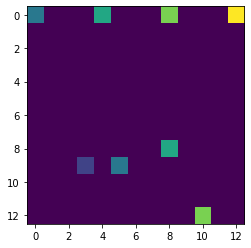

Step 7


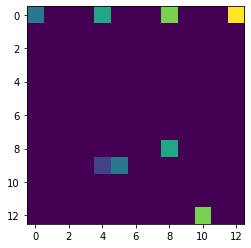

Step 8


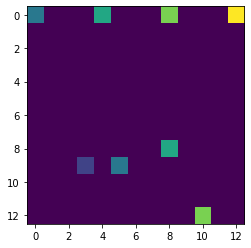

Step 9


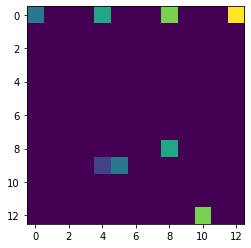

Step 10


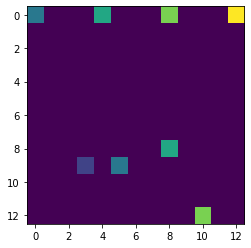

Step 11


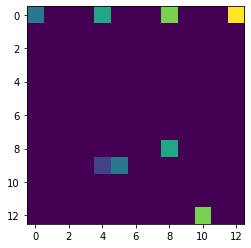

Step 12


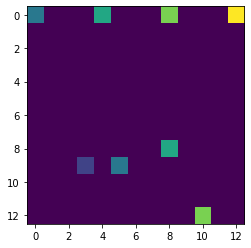

Step 13


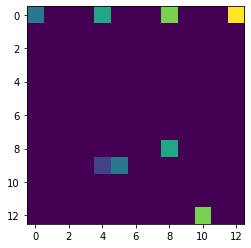

Step 14


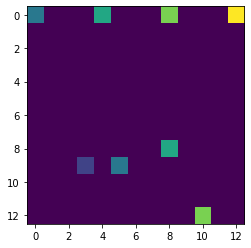

Step 15


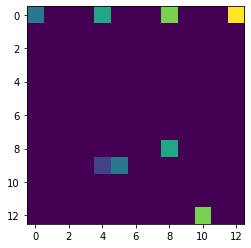

Step 16


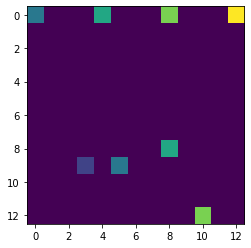

Step 17


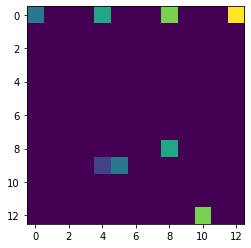

Step 18


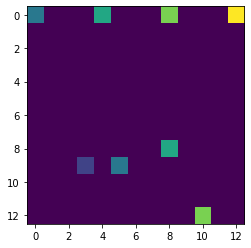

Step 19


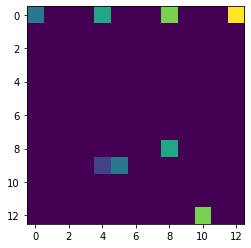

Step 20


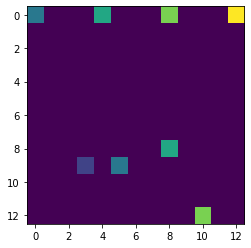

Step 21


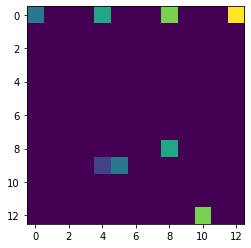

Step 22


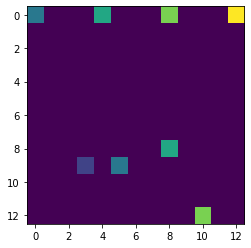

Step 23


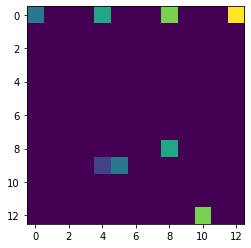

Step 24


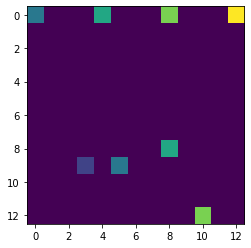

Step 25


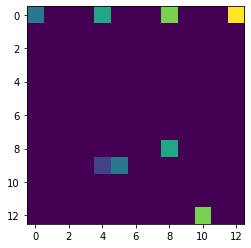

Step 26


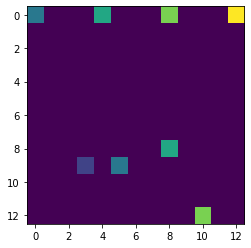

Step 27


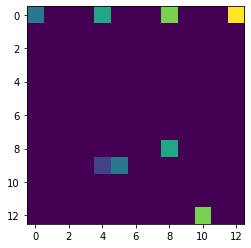

Step 28


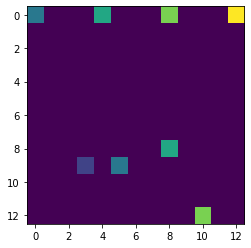

Step 29


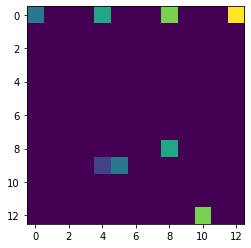

Step 30


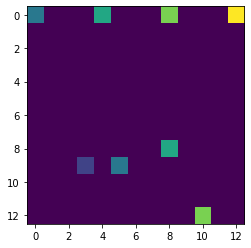

Step 31


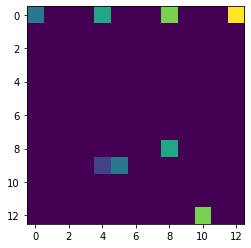

Step 32


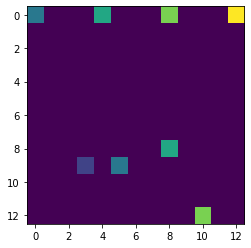

Step 33


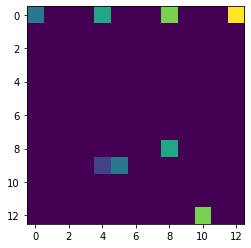

Step 34


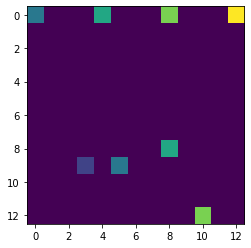

Step 35


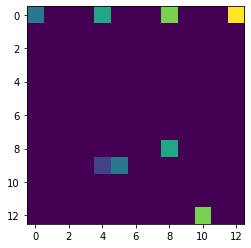

Step 36


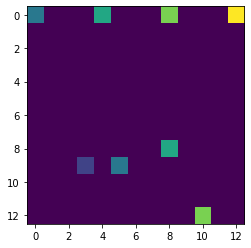

Step 37


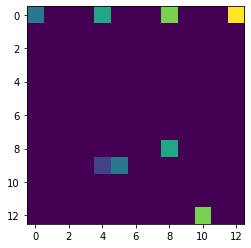

Step 38


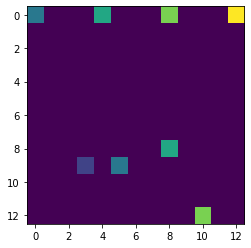

Step 39


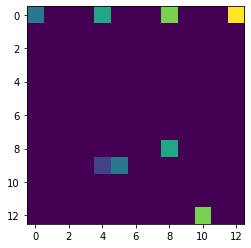

Step 40


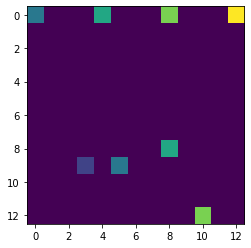

Step 41


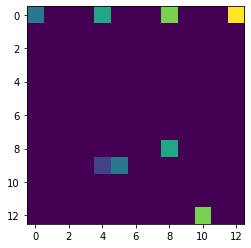

Step 42


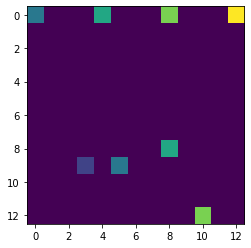

Step 43


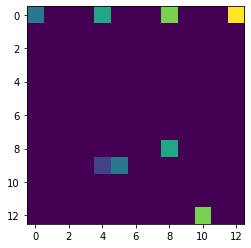

Step 44


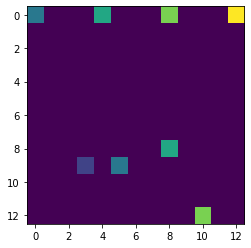

Step 45


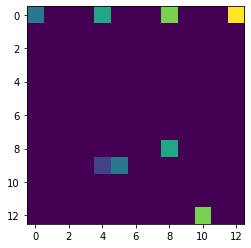

Step 46


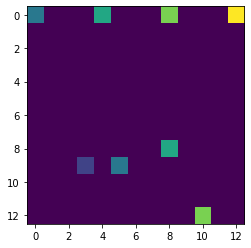

Step 47


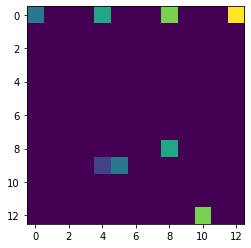

Step 48


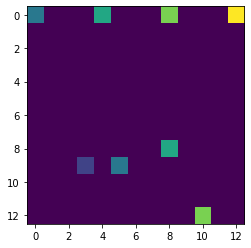

Step 49


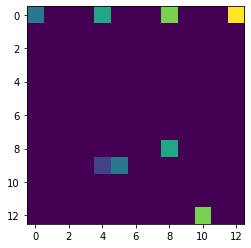

Step 50


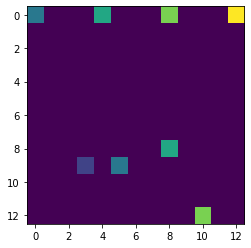

Step 51


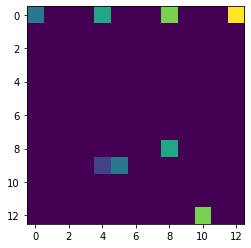

Step 52


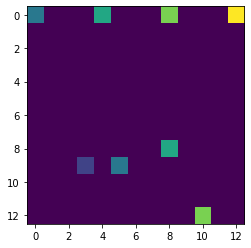

In [41]:
env3.reset()
states = [env3.reset()[0][0] * config3['GRID_SIZE'] + env3.reset()[0][1],
          env3.reset()[1][0] * config3['GRID_SIZE'] + env3.reset()[1][1],
          env3.reset()[2][0] * config3['GRID_SIZE'] + env3.reset()[2][1],
          env3.reset()[3][0] * config3['GRID_SIZE'] + env3.reset()[3][1]]

# Only carry out the optimal policy trained via Q-learning.
qlearning_agent1_4.eps = 0.0
qlearning_agent2_4.eps = 0.0
qlearning_agent3_4.eps = 0.0
qlearning_agent4_4.eps = 0.0
count = 0

while True:
    actions = [qlearning_agent1_4.get_action(states[0]),
               qlearning_agent2_4.get_action(states[1]),
               qlearning_agent3_4.get_action(states[2]),
               qlearning_agent4_4.get_action(states[3])]
    temp_random = 6 # the second agent has priority
    _, rewards, dones, _ = env3.step(actions, temp_random)
    next_states = [env3.agent_pos[0][0] * config3['GRID_SIZE'] + env3.agent_pos[0][1],
                   env3.agent_pos[1][0] * config3['GRID_SIZE'] + env3.agent_pos[1][1],
                   env3.agent_pos[2][0] * config3['GRID_SIZE'] + env3.agent_pos[2][1],
                   env3.agent_pos[3][0] * config3['GRID_SIZE'] + env3.agent_pos[3][1]]
    states = next_states
    count += 1

    print(f"Step {count}")
    env3.render()
    plt.show()
    time.sleep(1)
    
    if dones[0] + dones[1] + dones[2] + dones[3] > 0:
        break

In [48]:
start = time.time()

qlearning_rewards1 = []
qlearning_rewards2 = []
qlearning_rewards3 = []
qlearning_rewards4 = []
eps_values = []
print_every = 1000
factor = (1e-2)**(1 / 15000)

qlearning_agent1_5 = QLearner(gamma = gamma,
                              num_states = num_states3,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)
qlearning_agent2_5 = QLearner(gamma = gamma,
                              num_states = num_states3,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)
qlearning_agent3_5 = QLearner(gamma = gamma,
                              num_states = num_states3,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)
qlearning_agent4_5 = QLearner(gamma = gamma,
                              num_states = num_states3,
                              num_actions = num_actions,
                              eps = eps,
                              lr = lr)

for ep in range(15000):
    states = [env3.reset()[0][0] * config3['GRID_SIZE'] + env3.reset()[0][1],
              env3.reset()[1][0] * config3['GRID_SIZE'] + env3.reset()[1][1],
              env3.reset()[2][0] * config3['GRID_SIZE'] + env3.reset()[2][1],
              env3.reset()[3][0] * config3['GRID_SIZE'] + env3.reset()[3][1]]
    env3.reset()
    total_reward1 = 0
    total_reward2 = 0
    total_reward3 = 0
    total_reward4 = 0
    
    while True:
        # epsilon-greedy policy
        actions = [qlearning_agent1_5.get_action(states[0]),
                   qlearning_agent2_5.get_action(states[1]),
                   qlearning_agent3_5.get_action(states[2]),
                   qlearning_agent4_5.get_action(states[3])]
        temp_random = np.random.choice(24)
        _, rewards, dones, _ = env3.step(actions, temp_random)
        next_states = [env3.agent_pos[0][0] * config3['GRID_SIZE'] + env3.agent_pos[0][1],
                       env3.agent_pos[1][0] * config3['GRID_SIZE'] + env3.agent_pos[1][1],
                       env3.agent_pos[2][0] * config3['GRID_SIZE'] + env3.agent_pos[2][1],
                       env3.agent_pos[3][0] * config3['GRID_SIZE'] + env3.agent_pos[3][1]]
        
        # Q-learning: Update Q-table using greedy policy.
        qlearning_agent1_5.update_sample(state = states[0],
                                         action = actions[0],
                                         reward = rewards[0],
                                         next_state = next_states[0],
                                         done = dones[0])
        qlearning_agent2_5.update_sample(state = states[1],
                                         action = actions[1],
                                         reward = rewards[1],
                                         next_state = next_states[1],
                                         done = dones[1])
        qlearning_agent3_5.update_sample(state = states[2],
                                         action = actions[2],
                                         reward = rewards[2],
                                         next_state = next_states[2],
                                         done = dones[2])
        qlearning_agent4_5.update_sample(state = states[3],
                                         action = actions[3],
                                         reward = rewards[3],
                                         next_state = next_states[3],
                                         done = dones[3])
        
        total_reward1 += rewards[0]
        total_reward2 += rewards[1]
        total_reward3 += rewards[2]
        total_reward4 += rewards[3]
        
        states = next_states
        
        if dones[0] or dones[1] or dones[2] or dones[3]:
            break
            
    qlearning_rewards1.append(total_reward1)
    qlearning_rewards2.append(total_reward2)
    qlearning_rewards3.append(total_reward3)
    qlearning_rewards4.append(total_reward4)
    
    eps_values.append(qlearning_agent1_4.eps)
    
    qlearning_agent1_5.eps *= factor
    qlearning_agent2_5.eps *= factor
    qlearning_agent3_5.eps *= factor
    qlearning_agent4_5.eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {qlearning_agent1_5.eps:.2f}")
        
end = time.time()
print(f"For 4 agents, the elapsed time: {round(end - start, 1)} seconds")

Episode: 1000	| Epsilon: 0.74
Episode: 2000	| Epsilon: 0.54
Episode: 3000	| Epsilon: 0.40
Episode: 4000	| Epsilon: 0.29
Episode: 5000	| Epsilon: 0.22
Episode: 6000	| Epsilon: 0.16
Episode: 7000	| Epsilon: 0.12
Episode: 8000	| Epsilon: 0.09
Episode: 9000	| Epsilon: 0.06
Episode: 10000	| Epsilon: 0.05
Episode: 11000	| Epsilon: 0.03
Episode: 12000	| Epsilon: 0.03
Episode: 13000	| Epsilon: 0.02
Episode: 14000	| Epsilon: 0.01
Episode: 15000	| Epsilon: 0.01
For 4 agents, the elapsed time: 69.1 seconds


Step 1


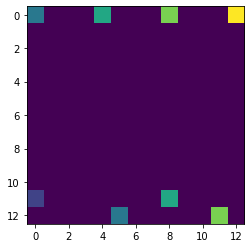

Step 2


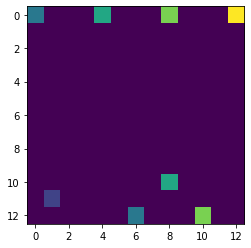

Step 3


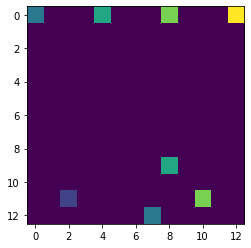

Step 4


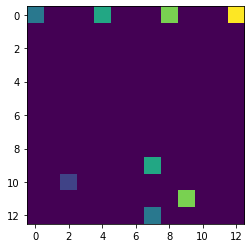

Step 5


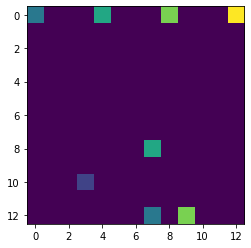

Step 6


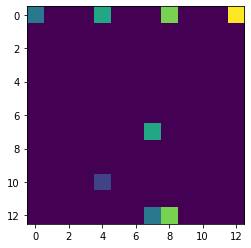

Step 7


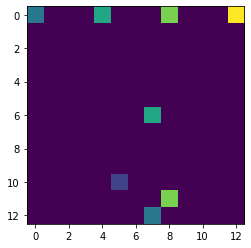

Step 8


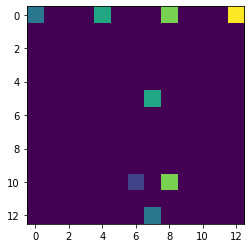

Step 9


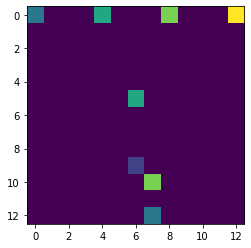

Step 10


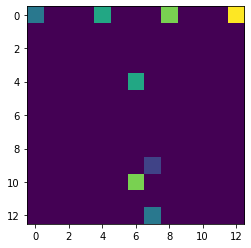

Step 11


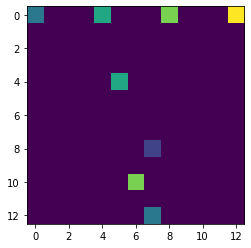

Step 12


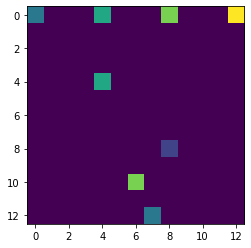

Step 13


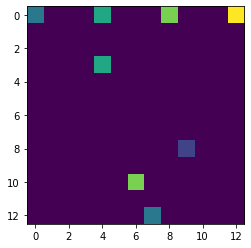

Step 14


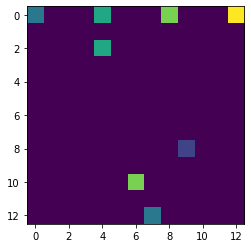

Step 15


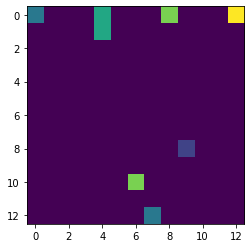

Step 16


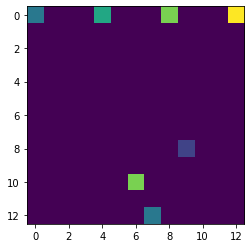

In [49]:
env3.reset()
states = [env3.reset()[0][0] * config3['GRID_SIZE'] + env3.reset()[0][1],
          env3.reset()[1][0] * config3['GRID_SIZE'] + env3.reset()[1][1],
          env3.reset()[2][0] * config3['GRID_SIZE'] + env3.reset()[2][1],
          env3.reset()[3][0] * config3['GRID_SIZE'] + env3.reset()[3][1]]

# Only carry out the optimal policy trained via Q-learning.
qlearning_agent1_5.eps = 0.0
qlearning_agent2_5.eps = 0.0
qlearning_agent3_5.eps = 0.0
qlearning_agent4_5.eps = 0.0
count = 0

while True:
    actions = [qlearning_agent1_5.get_action(states[0]),
               qlearning_agent2_5.get_action(states[1]),
               qlearning_agent3_5.get_action(states[2]),
               qlearning_agent4_5.get_action(states[3])]
    temp_random = np.random.choice(24)
    _, rewards, dones, _ = env3.step(actions, temp_random)
    next_states = [env3.agent_pos[0][0] * config3['GRID_SIZE'] + env3.agent_pos[0][1],
                   env3.agent_pos[1][0] * config3['GRID_SIZE'] + env3.agent_pos[1][1],
                   env3.agent_pos[2][0] * config3['GRID_SIZE'] + env3.agent_pos[2][1],
                   env3.agent_pos[3][0] * config3['GRID_SIZE'] + env3.agent_pos[3][1]]
    states = next_states
    count += 1

    print(f"Step {count}")
    env3.render()
    plt.show()
    time.sleep(1)
    
    if dones[0] + dones[1] + dones[2] + dones[3] > 0:
        break

Step 1


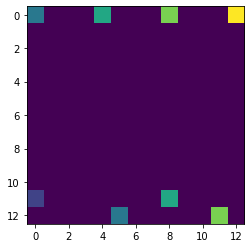

Step 2


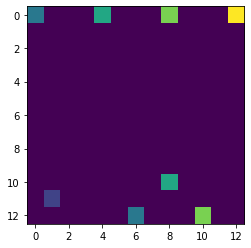

Step 3


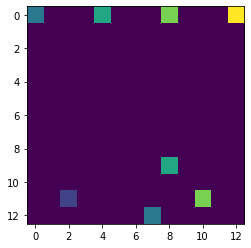

Step 4


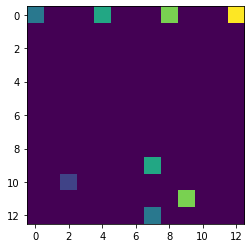

Step 5


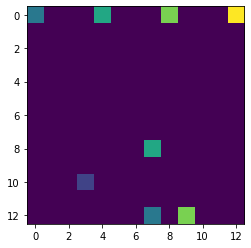

Step 6


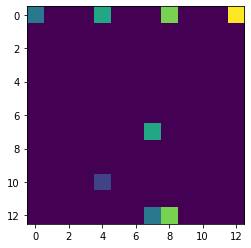

Step 7


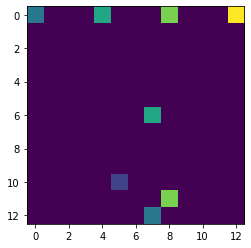

Step 8


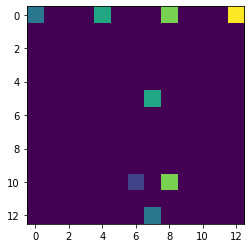

Step 9


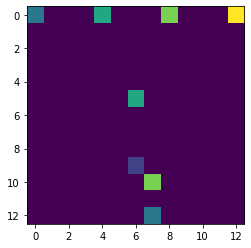

Step 10


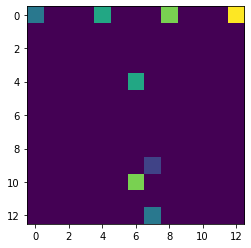

Step 11


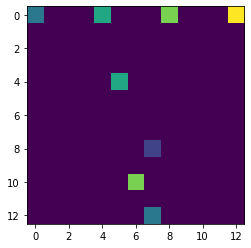

Step 12


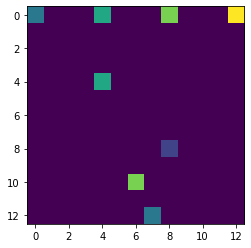

Step 13


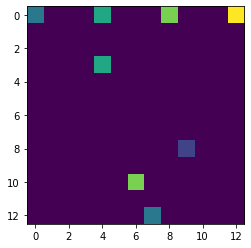

Step 14


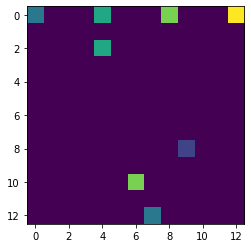

Step 15


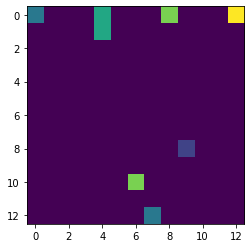

Step 16


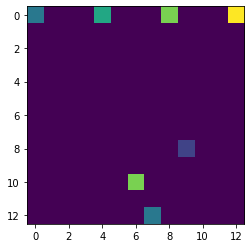

In [50]:
env3.reset()
states = [env3.reset()[0][0] * config3['GRID_SIZE'] + env3.reset()[0][1],
          env3.reset()[1][0] * config3['GRID_SIZE'] + env3.reset()[1][1],
          env3.reset()[2][0] * config3['GRID_SIZE'] + env3.reset()[2][1],
          env3.reset()[3][0] * config3['GRID_SIZE'] + env3.reset()[3][1]]

# Only carry out the optimal policy trained via Q-learning.
qlearning_agent1_5.eps = 0.0
qlearning_agent2_5.eps = 0.0
qlearning_agent3_5.eps = 0.0
qlearning_agent4_5.eps = 0.0
count = 0

while True:
    actions = [qlearning_agent1_5.get_action(states[0]),
               qlearning_agent2_5.get_action(states[1]),
               qlearning_agent3_5.get_action(states[2]),
               qlearning_agent4_5.get_action(states[3])]
    temp_random = 12 # The second agent has the priority.
    _, rewards, dones, _ = env3.step(actions, temp_random)
    next_states = [env3.agent_pos[0][0] * config3['GRID_SIZE'] + env3.agent_pos[0][1],
                   env3.agent_pos[1][0] * config3['GRID_SIZE'] + env3.agent_pos[1][1],
                   env3.agent_pos[2][0] * config3['GRID_SIZE'] + env3.agent_pos[2][1],
                   env3.agent_pos[3][0] * config3['GRID_SIZE'] + env3.agent_pos[3][1]]
    states = next_states
    count += 1

    print(f"Step {count}")
    env3.render()
    plt.show()
    time.sleep(1)
    
    if dones[0] + dones[1] + dones[2] + dones[3] > 0:
        break